In [1]:
library(tidyverse)
library(patchwork)
library(paletteer)
library(ggrepel)
library(scales)
library(ggpubr)
library(ggbeeswarm)

── Attaching packages ────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.5.2     ✔ purrr   1.0.2
✔ tibble  3.3.0     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ───────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




# Tuning BLASTn parameters on subsamples of the K562 MPRA dataset

In [2]:
project_dir <- "/home/brett/work/OrthogonalTrainValSplits/hashFrag_paper"
analysis_dir <- file.path(project_dir,"raw")
recall_dir <- file.path(analysis_dir,"recall","subsample")

In [113]:
pathlist <- list.files(recall_dir,pattern=".blastn.recall.csv.gz",full.names=T)
dfs <- lapply(pathlist,read.csv)
names(dfs) <- sub(".blastn.recall.csv.gz","",basename(pathlist))
df <- bind_rows(dfs, .id = "file_label") %>%
    separate(file_label,into=c("dataset","subsample","word_size","max_target_seqs","e_value","dust"),sep="\\.") %>%
    mutate(
        subsample = as.integer(sub("subsample_","",subsample)),
        word_size = as.integer(sub("wordsize_","",word_size)),
        max_target_seqs = as.integer(sub("maxtargetseqs_","",max_target_seqs)),
        e_value = as.integer(sub("evalue_","",e_value)),
        dust = dust == "dust_yes"
    )
head(df)
dim(df)

,dataset,subsample,word_size,max_target_seqs,e_value,dust,threshold,TP,FP,TN,FN,recall,FPR
,<chr>,<int>,<int>,<int>,<int>,<lgl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,K562_clean,1,11,1000,10,FALSE,3,117645,0,0,49877355,0.002353135,0.0000000000
2,K562_clean,1,11,1000,10,FALSE,4,117645,0,1,49877354,0.002353135,0.0000000000
3,K562_clean,1,11,1000,10,FALSE,5,117645,0,17,49877338,0.002353136,0.0000000000
4,K562_clean,1,11,1000,10,FALSE,6,117645,0,1435,49875920,0.002353203,0.0000000000
5,K562_clean,1,11,1000,10,FALSE,7,117635,10,54916,49822439,0.002355523,0.0001820631
6,K562_clean,1,11,1000,10,FALSE,8,117360,285,726709,49150646,0.002382073,0.0003920252


[1] 215040     13

`summarise()` has grouped output by 'threshold'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups`
argument.


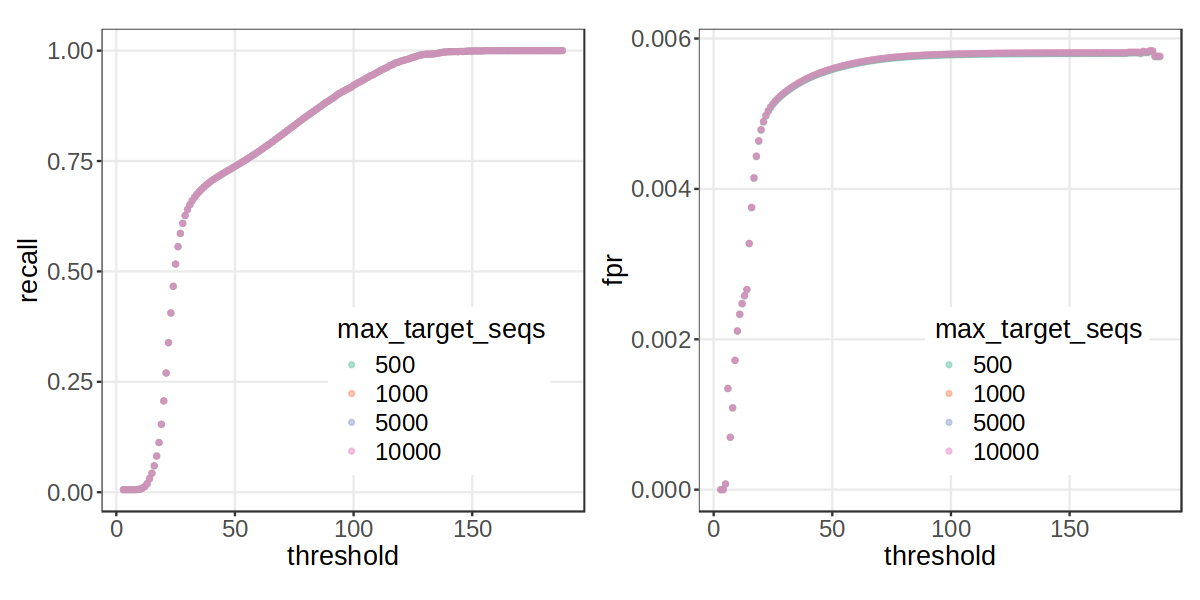

In [114]:
options(repr.plot.width=10,repr.plot.height=5)

p_max_target_seqs_recall <- df %>%
    group_by(threshold,max_target_seqs) %>%
    summarize(recall = mean(recall)) %>%
    ggplot(aes(x=threshold,y=recall,color=factor(max_target_seqs))) +
    # geom_line(aes(group=max_target_seqs),linewidth=1.5,alpha=0.5) +
    geom_point(size=1,alpha=0.5) +
    scale_color_brewer(palette="Set2",name="max_target_seqs") +
    theme_bw() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = c(0.7,0.25),
        aspect.ratio = 1
    )

p_max_target_seqs_fpr <- df %>%
    group_by(threshold,max_target_seqs) %>%
    summarize(fpr = mean(FPR)) %>%
    ggplot(aes(x=threshold,y=fpr,color=factor(max_target_seqs))) +
    geom_point(size=1,alpha=0.5) +
    scale_color_brewer(palette="Set2",name="max_target_seqs") +
    theme_bw() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = c(0.7,0.25),
        aspect.ratio = 1
    )

p_max_target_seqs <- (p_max_target_seqs_recall | p_max_target_seqs_fpr + plot_layout(axis_titles = "collect"))
p_max_target_seqs

`summarise()` has grouped output by 'threshold'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups`
argument.


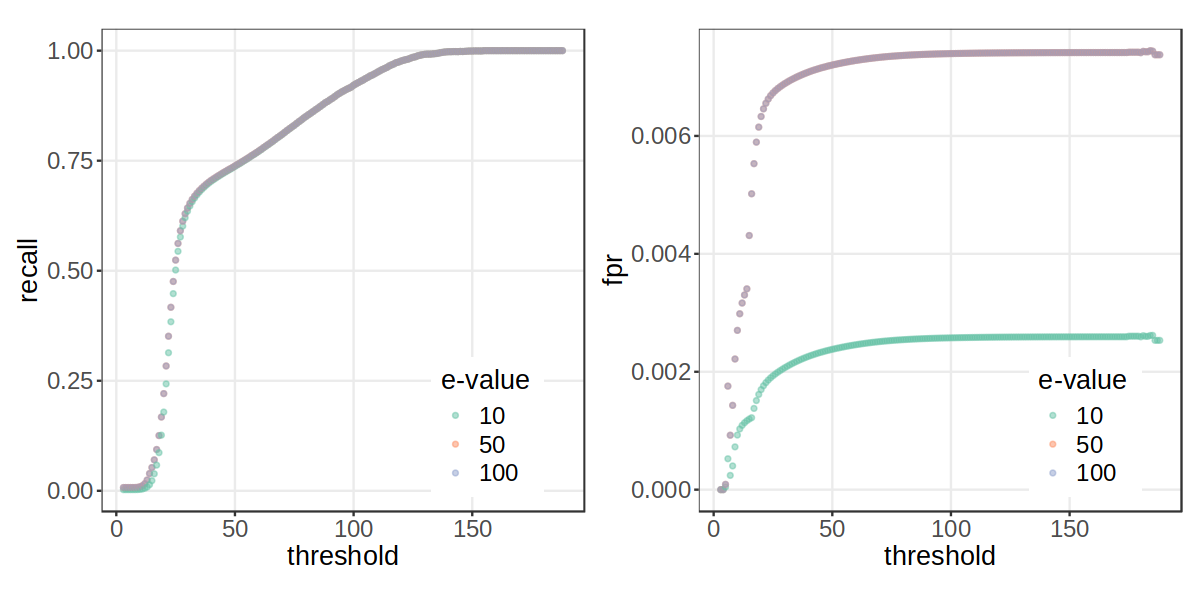

In [115]:
options(repr.plot.width=10,repr.plot.height=5)

p_e_value_recall <- df %>%
    group_by(threshold,e_value) %>%
    summarize(recall = mean(recall)) %>%
    ggplot(aes(x=threshold,y=recall,color=factor(e_value))) +
    # geom_line(aes(group=max_target_seqs),linewidth=1.5,alpha=0.5) +
    geom_point(size=1,alpha=0.5) +
    scale_color_brewer(palette="Set2",name="e-value") +
    theme_bw() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = c(0.8,0.175),
        aspect.ratio = 1
    )

p_e_value_fpr <- df %>%
    group_by(threshold,e_value) %>%
    summarize(fpr = mean(FPR)) %>%
    ggplot(aes(x=threshold,y=fpr,color=factor(e_value))) +
    geom_point(size=1,alpha=0.5) +
    scale_color_brewer(palette="Set2",name="e-value") +
    theme_bw() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = c(0.8,0.175),
        aspect.ratio = 1
    )

p_e_value <- (p_e_value_recall | p_e_value_fpr + plot_layout(axis_titles = "collect"))
p_e_value

`summarise()` has grouped output by 'threshold'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups`
argument.


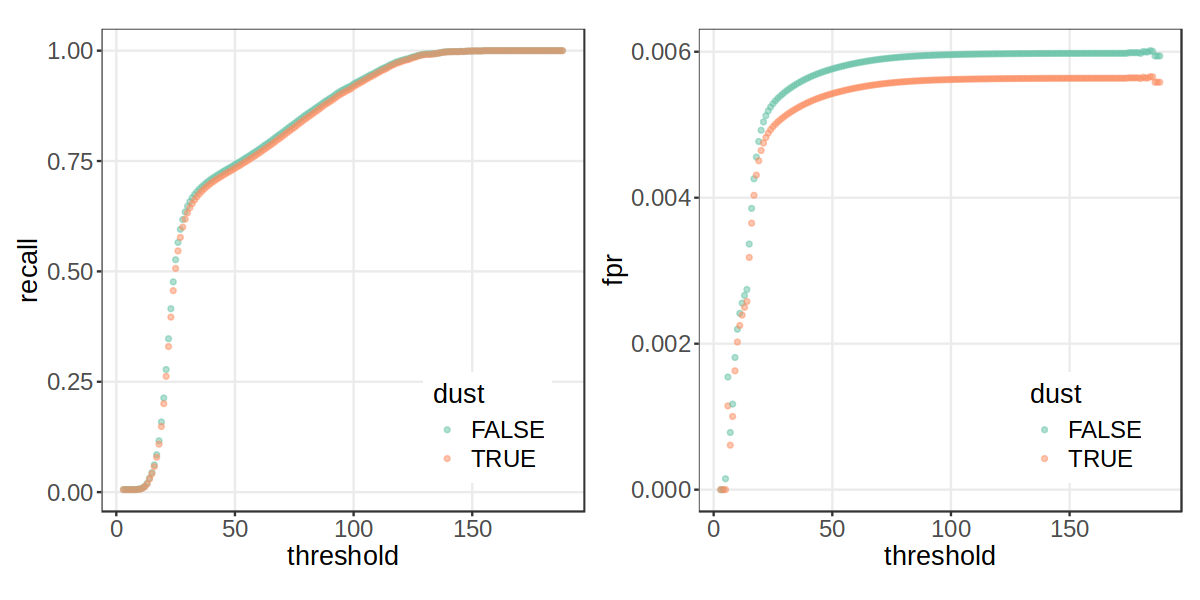

In [116]:
options(repr.plot.width=10,repr.plot.height=5)

p_dust_recall <- df %>%
    group_by(threshold,dust) %>%
    summarize(recall = mean(recall)) %>%
    ggplot(aes(x=threshold,y=recall,color=factor(dust))) +
    # geom_line(aes(group=max_target_seqs),linewidth=1.5,alpha=0.5) +
    geom_point(size=1,alpha=0.5) +
    scale_color_brewer(palette="Set2",name="dust") +
    theme_bw() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = c(0.8,0.175),
        aspect.ratio = 1
    )

p_dust_fpr <- df %>%
    group_by(threshold,dust) %>%
    summarize(fpr = mean(FPR)) %>%
    ggplot(aes(x=threshold,y=fpr,color=factor(dust))) +
    geom_point(size=1,alpha=0.5) +
    scale_color_brewer(palette="Set2",name="dust") +
    theme_bw() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = c(0.8,0.175),
        aspect.ratio = 1
    )

p_dust <- (p_dust_recall | p_dust_fpr + plot_layout(axis_titles = "collect"))
p_dust

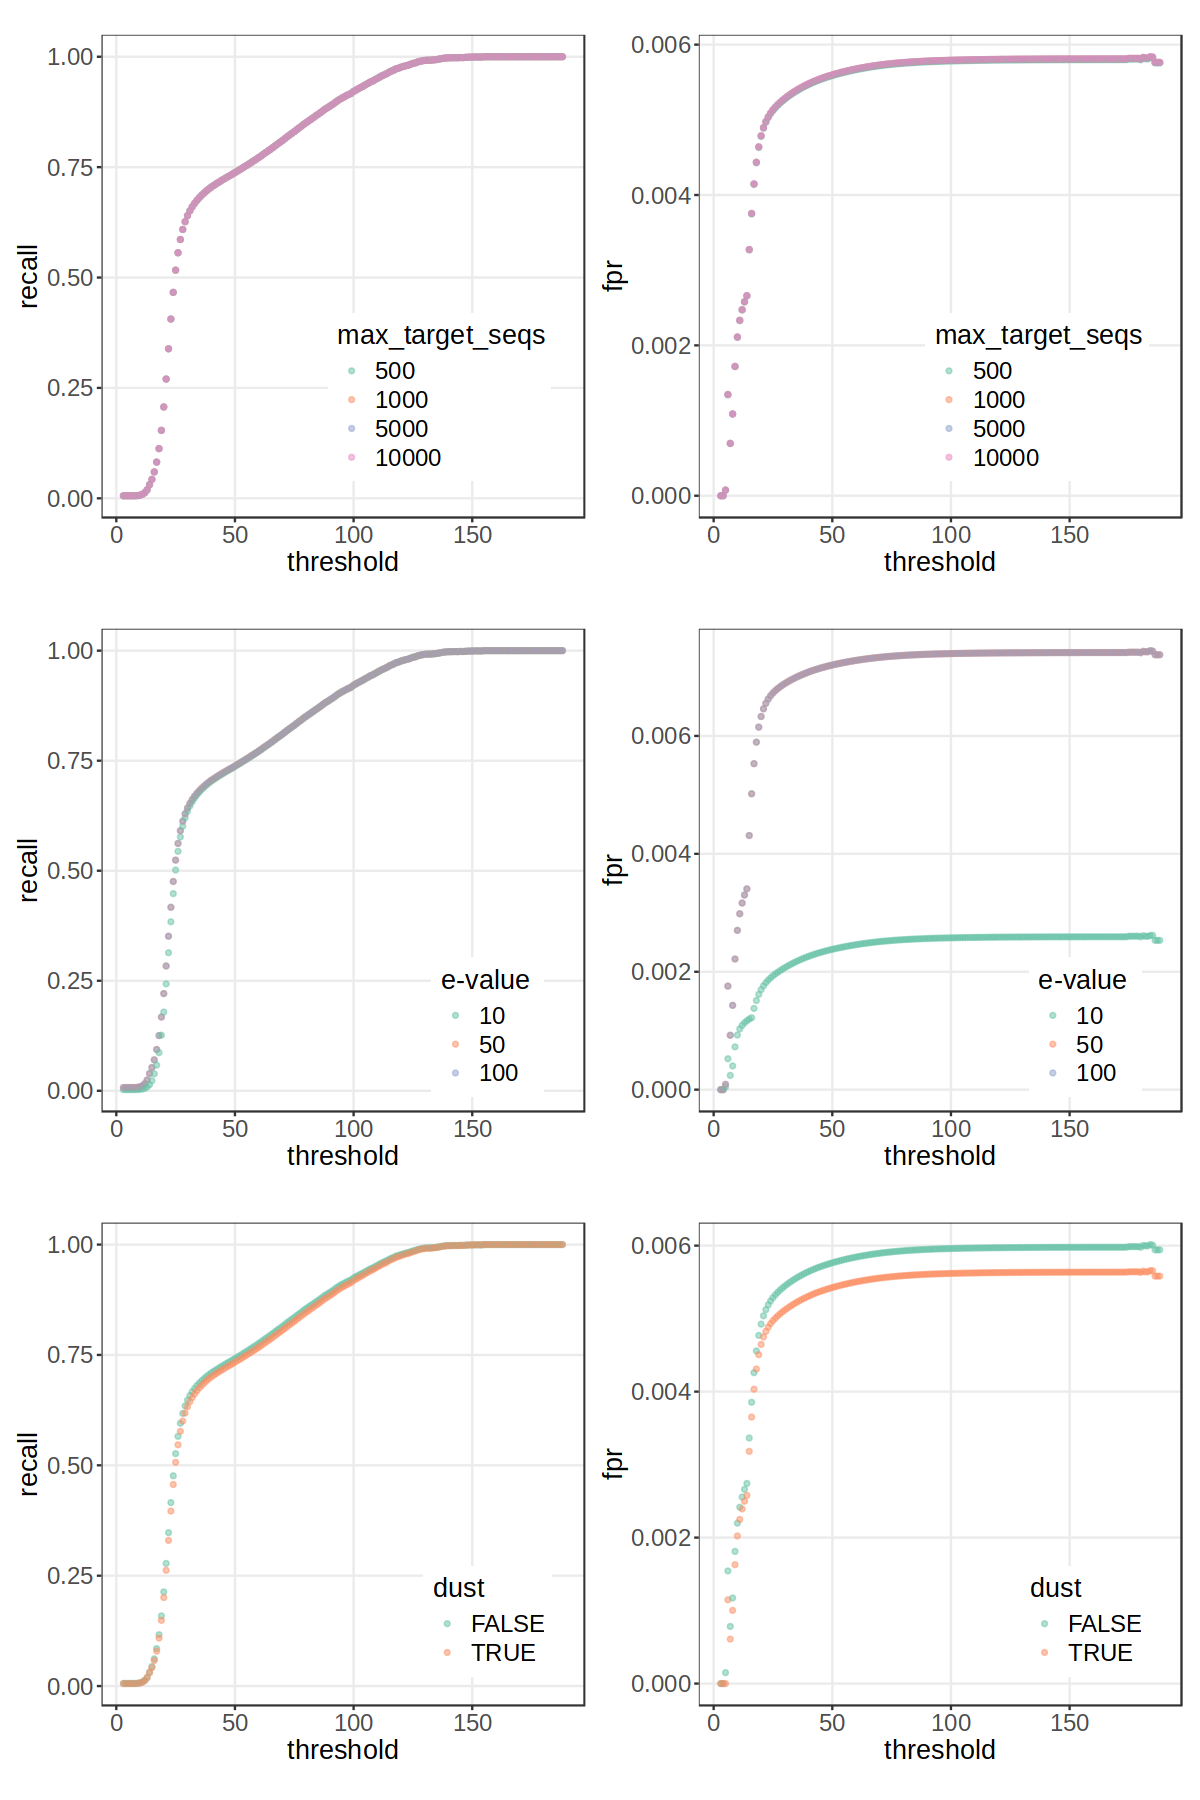

In [120]:
options(repr.plot.width=10,repr.plot.height=15)

p_marginalized_params <- p_max_target_seqs / p_e_value / p_dust
outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.K562_subsample_tuning.marginalized_params.png"
ggsave(outpath,plot=p_marginalized_params,width=10,height=15,dpi="retina")

outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.K562_subsample_tuning.marginalized_params.tiff"
ggsave(outpath,plot=p_marginalized_params,width=10,height=15,dpi="retina")

p_marginalized_params

In [34]:
w <- 5
processed_df <- df %>%
    filter(word_size == w) %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(recall = mean(recall)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; "),
        label = factor(label,levels=sort(label))
    ) %>%
    ungroup() %>%
    dplyr::select(-e_value,-dust)

options(repr.plot.width=5,repr.plot.height=5)

p_out <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line() +
    geom_point() +
    scale_color_paletteer_d(palette="ggsci::nrc_npg",name="Parameter combination") +
    scale_x_continuous(limits=c(0,200),breaks=seq(0,200,40)) +
    theme_bw() + theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        axis.title.x = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16,hjust=0.5),
        plot.title = element_text(size=18,hjust=0.5),
    ) +
    guides(color=guide_legend(override.aes=list(size=3))) +
    labs(x="SW threshold",y="Recall",title=paste0("Word size: ",w))

p_in <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line(linewidth=0.5) +
    geom_point(size=1) +
    scale_color_paletteer_d(palette="ggsci::nrc_npg") +
    coord_cartesian(xlim=c(25,45),ylim=c(0.9,1)) +
    scale_x_continuous(breaks=seq(25,45,10)) +
    scale_y_continuous(breaks=seq(0.9,1,0.05)) +
    theme_bw() + theme(
        legend.position = "none",
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
    )

p5 <- p_out + inset_element(p_in,left=0.425,bottom=0.025,right=0.975,top=0.5)

`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can override using the `.groups` argument.


In [35]:
w <- 7
processed_df <- df %>%
    filter(word_size == w) %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(recall = mean(recall)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; "),
        label = factor(label,levels=sort(label))
    ) %>%
    ungroup() %>%
    dplyr::select(-e_value,-dust)

options(repr.plot.width=5,repr.plot.height=5)

p_out <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line() +
    geom_point() +
    scale_color_paletteer_d(palette="ggsci::nrc_npg",name="Parameter combination") +
    scale_x_continuous(limits=c(0,200),breaks=seq(0,200,40)) +
    theme_bw() + theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16,hjust=0.5),
        plot.title = element_text(size=18,hjust=0.5),
    ) +
    guides(color=guide_legend(override.aes=list(size=3))) +
    labs(x="SW threshold",y="Recall",title=paste0("Word size: ",w))

p_in <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line(linewidth=0.5) +
    geom_point(size=1) +
    scale_color_paletteer_d(palette="ggsci::nrc_npg") +
    coord_cartesian(xlim=c(25,45),ylim=c(0.9,1)) +
    scale_x_continuous(breaks=seq(25,45,10)) +
    scale_y_continuous(breaks=seq(0.9,1,0.05)) +
    theme_bw() + theme(
        legend.position = "none",
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
    )

p7 <- p_out + inset_element(p_in,left=0.425,bottom=0.025,right=0.975,top=0.5)

`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can override using the `.groups` argument.


In [36]:
w <- 11
processed_df <- df %>%
    filter(word_size == w) %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(recall = mean(recall)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; "),
        label = factor(label,levels=sort(label))
    ) %>%
    ungroup() %>%
    dplyr::select(-e_value,-dust)

options(repr.plot.width=8,repr.plot.height=5)

p_out <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line() +
    geom_point() +
    scale_color_paletteer_d(palette="ggsci::nrc_npg",name="Parameters") +
    scale_x_continuous(limits=c(0,200),breaks=seq(0,200,40)) +
    theme_bw() + theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16,hjust=0.5),
        plot.title = element_text(size=18,hjust=0.5),
    ) +
    guides(color=guide_legend(override.aes=list(size=3))) +
    labs(x="SW threshold",y="Recall",title=paste0("Word size: ",w))

p_in <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line(linewidth=0.5) +
    geom_point(size=1) +
    scale_color_paletteer_d(palette="ggsci::nrc_npg") +
    coord_cartesian(xlim=c(40,120),ylim=c(0.9,1)) +
    scale_x_continuous(breaks=seq(40,120,40)) +
    scale_y_continuous(breaks=seq(0.9,1,0.05)) +
    theme_bw() + theme(
        legend.position = "none",
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
    )

p11 <- p_out + inset_element(p_in,left=0.425,bottom=0.025,right=0.975,top=0.5)

`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can override using the `.groups` argument.


In [37]:
w <- 16
processed_df <- df %>%
    filter(word_size == w) %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(recall = mean(recall)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; "),
        label = factor(label,levels=sort(label))
    ) %>%
    ungroup() %>%
    dplyr::select(-e_value,-dust)

options(repr.plot.width=8,repr.plot.height=5)

p_out <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line() +
    geom_point() +
    scale_color_paletteer_d(palette="ggsci::nrc_npg",name="Parameters") +
    scale_x_continuous(limits=c(0,200),breaks=seq(0,200,40)) +
    theme_bw() + theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16,hjust=0.5),
        plot.title = element_text(size=18,hjust=0.5),
    ) +
    guides(color=guide_legend(override.aes=list(size=3))) +
    labs(x="SW threshold",y="Recall",title=paste0("Word size: ",w))

p_in <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line(linewidth=0.5) +
    geom_point(size=1) +
    scale_color_paletteer_d(palette="ggsci::nrc_npg") +
    coord_cartesian(xlim=c(100,140),ylim=c(0.9,1)) +
    scale_x_continuous(breaks=seq(100,140,20)) +
    scale_y_continuous(breaks=seq(0.9,1,0.05)) +
    theme_bw() + theme(
        legend.position = "none",
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
    )

p16 <- p_out + inset_element(p_in,left=0.425,bottom=0.025,right=0.975,top=0.5)

`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can override using the `.groups` argument.


In [38]:
w <- 20
processed_df <- df %>%
    filter(word_size == w) %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(recall = mean(recall)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; "),
        label = factor(label,levels=sort(label))
    ) %>%
    ungroup() %>%
    dplyr::select(-e_value,-dust)

options(repr.plot.width=8,repr.plot.height=5)

p_out <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line() +
    geom_point() +
    scale_color_paletteer_d(palette="ggsci::nrc_npg",name="Parameters") +
    scale_x_continuous(limits=c(0,200),breaks=seq(0,200,40)) +
    theme_bw() + theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16,hjust=0.5),
        plot.title = element_text(size=18,hjust=0.5),
    ) +
    guides(color=guide_legend(override.aes=list(size=3))) +
    labs(x="SW threshold",y="Recall",title=paste0("Word size: ",w))

p_in <- ggplot(processed_df,aes(x=threshold,y=recall,color=label,group=label)) +
    geom_line(linewidth=0.5) +
    geom_point(size=1) +
    scale_color_paletteer_d(palette="ggsci::nrc_npg") +
    coord_cartesian(xlim=c(120,160),ylim=c(0.9,1)) +
    scale_x_continuous(breaks=seq(120,160,20)) +
    scale_y_continuous(breaks=seq(0.9,1,0.05)) +
    theme_bw() + theme(
        legend.position = "none",
        axis.text = element_text(size=14),
        axis.title = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
    )

p20 <- p_out + inset_element(p_in,left=0.425,bottom=0.025,right=0.975,top=0.5)

`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can override using the `.groups` argument.


In [39]:
options(repr.plot.width=24,repr.plot.height=8)
p_top <- p5 | p7 | p11 | p16 | p20

In [40]:
processed_df <- df %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(fpr = mean(FPR)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; "),
        label = factor(label,levels=sort(label)),
        word_size = paste0("Word size: ",word_size),
        word_size = factor(word_size,levels=c("Word size: 5","Word size: 7","Word size: 11","Word size: 16","Word size: 20"))
    ) %>%
    ungroup() %>%
    dplyr::select(-e_value,-dust)

options(repr.plot.width=24,repr.plot.height=8)

p_bot <- ggplot(processed_df,aes(x=threshold,y=fpr,color=label,group=label)) +
    geom_line(linewidth=0.5,alpha=0.75) +
    geom_point(size=1,alpha=1) +
    scale_color_paletteer_d(palette="ggsci::nrc_npg",name="Parameters") +
    scale_x_continuous(limits=c(0,200),breaks=seq(0,200,40)) +
    scale_y_continuous(limits=c(0,0.02),breaks=seq(0,0.02,0.005)) +
    theme_bw() + theme(
        legend.position = "bottom",
        panel.grid = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16,hjust=0.5),
        plot.title = element_text(size=18,hjust=0.5),
        strip.text = element_text(size=18),
        strip.background = element_blank()
    ) +
    facet_wrap(~word_size,nrow=1,scales="free_y") +
    guides(color=guide_legend(override.aes=list(size=3))) +
    labs(x="SW threshold",y="False-Positive Rate")


`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can override using the `.groups` argument.


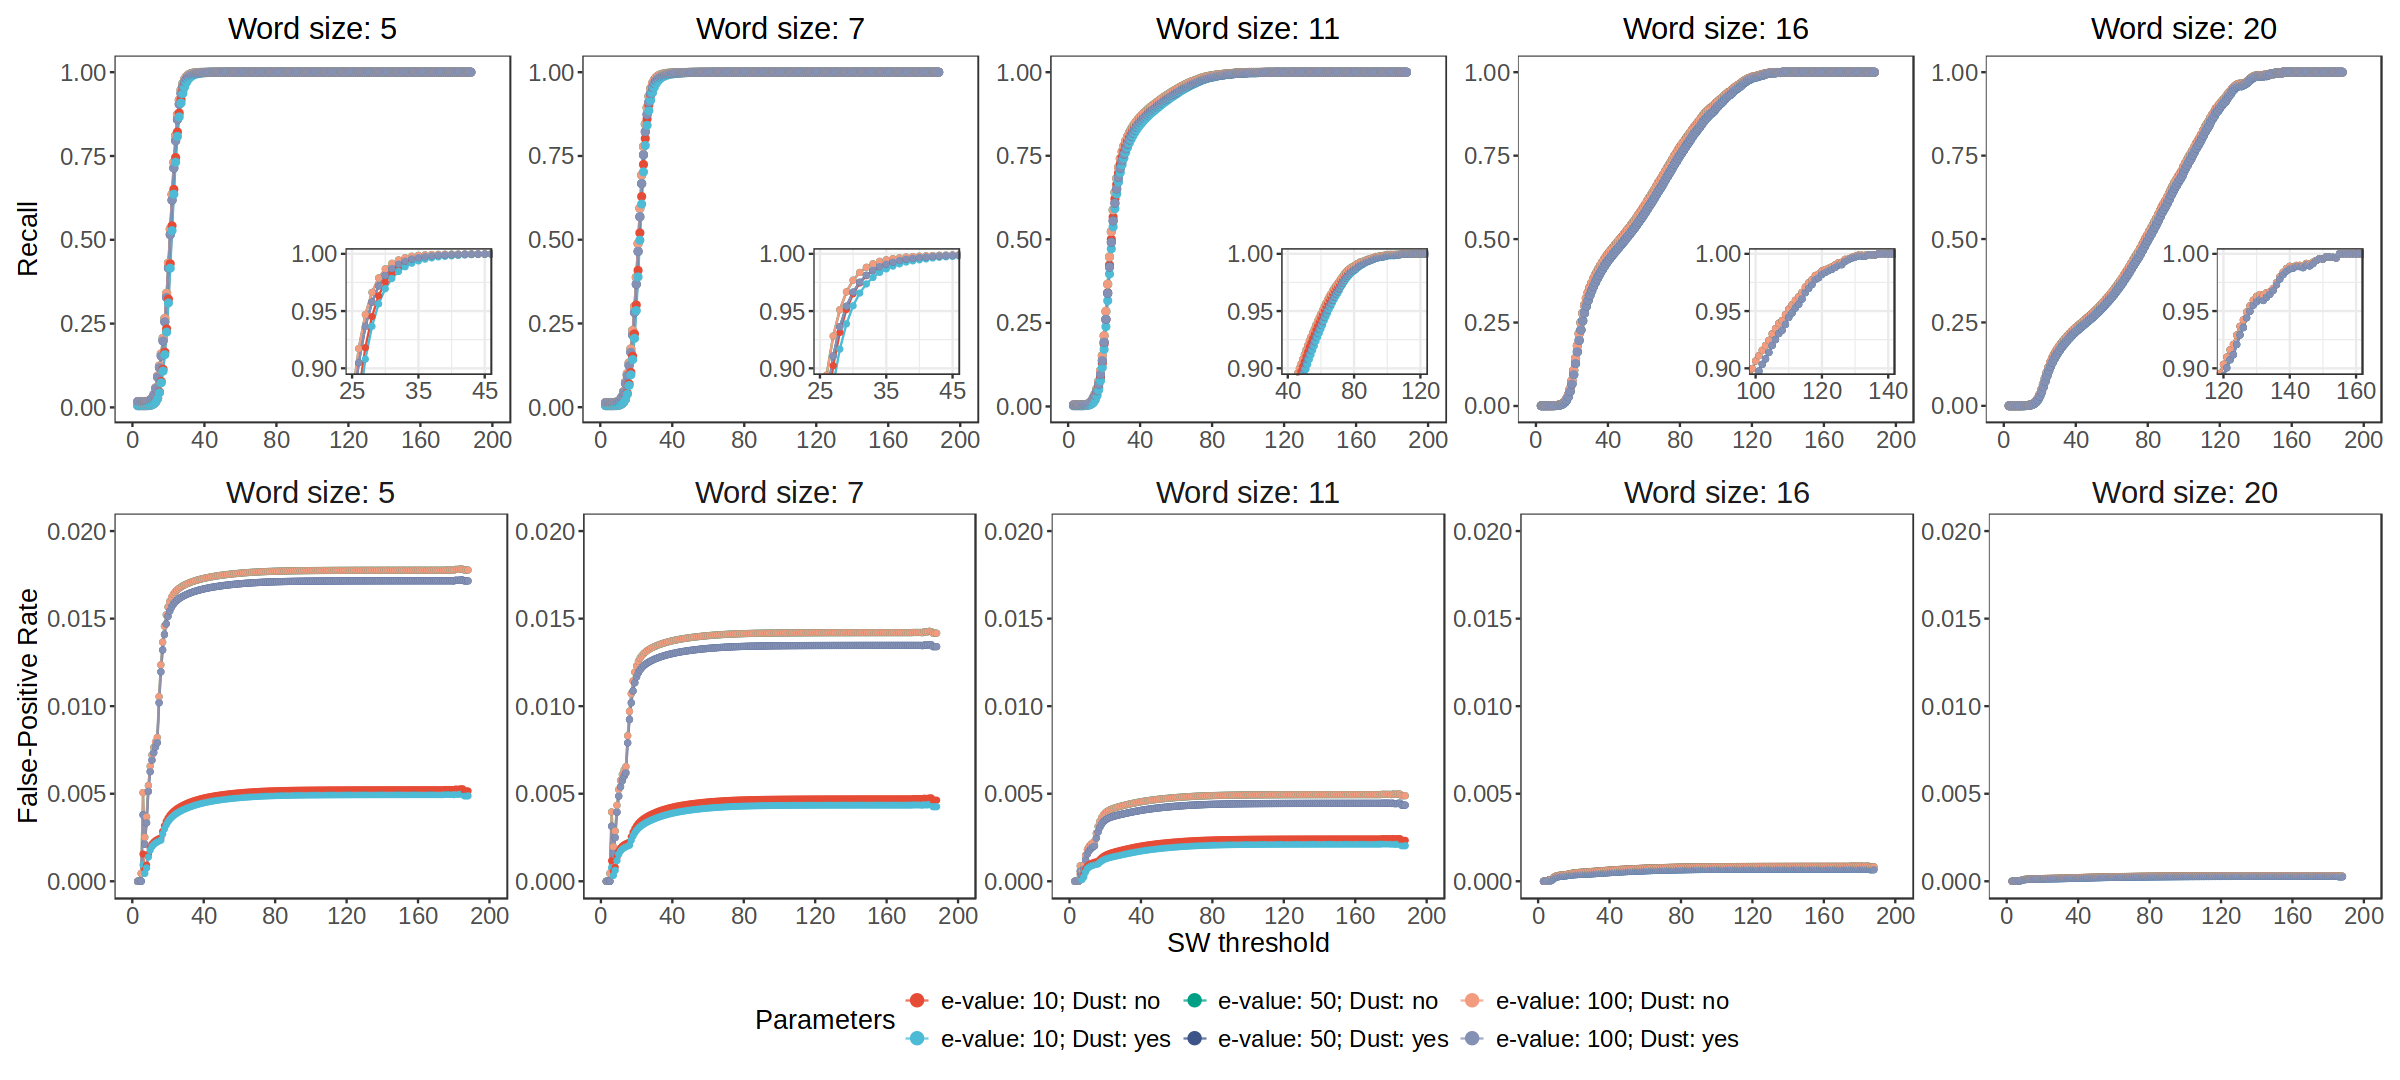

In [54]:
options(repr.plot.width=20,repr.plot.height=9)
p_tuning  <- p_top / p_bot + plot_layout(heights=c(1,1.05))

outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.K562_subsample_tuning.tiff"
ggsave(outpath,plot=p_tuning,width=20,height=9,dpi="retina")

p_tuning

# hashFrag main figure

In [3]:
analysis_dir <- "/home/brett/work/OrthogonalTrainValSplits/hashFrag_paper/raw"
runtime_path           <- file.path(analysis_dir,"hashFrag.runtime_analysis.csv.gz")
best_epoch_path        <- file.path(analysis_dir,"additional_analyses","hashFrag_blast_model_eval","best_epochs_per_condition_rnn.csv")
max_blast_scores_path  <- file.path(analysis_dir,"hashFrag.max_sw_score_distribution.txt.gz")
max_chrom_scores_path  <- file.path(analysis_dir,"chrom.max_sw_score_distribution.txt.gz")
model_performance_path <- file.path(analysis_dir,"gosai.chrom_vs_hashFrag.model.performance.csv.gz")
strat_performance_path <- file.path(analysis_dir,"hashFrag.homology_stratified_performance.csv.gz")
cross_fold_sw_path     <- file.path(analysis_dir,"K562_clean.chrom_vs_hashFrag.cross_fold_max_sw_analysis.csv.gz")
recall_path            <- file.path(analysis_dir,"K562_clean.complete.wordsize_7.compiled_recall.csv.gz")

In [4]:
recall_df <- read.csv(recall_path) %>%
    group_by(threshold) %>%
    summarize(
        total_tp = sum(TP),
        total_fp = sum(FP),
        total_tn = sum(TN),
        total_fn = sum(FN)
    ) %>%
    mutate(
        recall = total_tp/(total_tp+total_fn),
        N = total_fp+total_tn,
        fpr = total_fp/N
    ) %>%
    filter(!is.nan(fpr))
head(recall_df)
dim(recall_df)

threshold,total_tp,total_fp,total_tn,total_fn,recall,N,fpr
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,49036233,0,573,26526623194,0.001845156,573,0
5,49036233,0,31775,26526591992,0.001845158,31775,0
6,49036233,0,832553,26525791214,0.001845214,832553,0
7,49036233,0,30414273,26496209494,0.001847270,30414273,0
8,49036233,0,395464679,26131159088,0.001873028,395464679,0
9,49036233,0,2327804792,24198818975,0.002022292,2327804792,0


[1] 197   8

In [13]:
p_2b <- recall_df %>%
    mutate(
        highlight = ifelse(threshold %in% c(60),as.character(round(recall,4)),""),
        highlight_flag = ifelse(threshold %in% c(60),T,F)
    ) %>%
    ggplot(aes(x=threshold,y=recall)) +
    geom_line(linewidth=0.75,alpha=0.75,color="#1f77b4") +
    geom_point(data = . %>% filter(!highlight_flag),alpha=0.75,color="#1f77b4") +
    geom_text_repel(
        data = . %>% filter(highlight_flag),
        aes(label=highlight),
        direction="both",nudge_y=-0.1,nudge_x=20,segment.color="#404040",size=6,point.padding=1
    ) +
    geom_point(data = . %>% filter(highlight_flag),size=5,color="red") +
    scale_size_manual(values=c(2,4)) +
    scale_x_continuous(breaks=seq(0,200,40),limits=c(0,200)) +
    theme_bw() + theme(
        # panel.grid.minor = element_blank(),
        legend.position  = "bottom",
        strip.text       = element_text(color="black",size=16),
        strip.background = element_blank(),
        axis.text        = element_text(size=16),
        axis.text.x = element_blank(),
        axis.title       = element_text(size=18),
        legend.title     = element_text(size=18),
        legend.text      = element_text(size=16),
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin = unit(c(0.5,0.5,0.5,0.5),"cm")
    ) +
    labs(
        x="SW threshold",
        y="Recall",
    )

In [11]:
p_2c <- recall_df %>%
    mutate(
        highlight = ifelse(threshold %in% c(60),as.character(round(fpr,4)),""),
        highlight_flag = ifelse(threshold %in% c(60),T,F)
    ) %>%
    ggplot(aes(x=threshold,y=fpr)) +
    geom_line(linewidth=0.75,alpha=0.75,color="#1f77b4") +
    geom_point(data = . %>% filter(!highlight_flag),alpha=0.75,color="#1f77b4") +
    geom_text_repel(
        data = . %>% filter(highlight_flag),
        aes(label=highlight),
        direction="both",nudge_y=-0.000075,nudge_x=30,segment.color="#404040",size=6,point.padding=1
    ) +
    geom_point(data = . %>% filter(highlight_flag),size=5,color="red") +
    scale_size_manual(values=c(2,4)) +
    scale_x_continuous(breaks=seq(0,200,40),limits=c(0,200)) +
    theme_bw() + theme(
         #panel.grid.minor = element_blank(),
        legend.position  = "bottom",
        strip.text       = element_text(color="black",size=16),
        strip.background = element_blank(),
        axis.text        = element_text(size=16),
        axis.title       = element_text(size=18),
        legend.title     = element_text(size=18),
        legend.text      = element_text(size=16),
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin = unit(c(0.5,0.5,0.5,0.5),"cm")
    ) +
    labs(
        x="SW threshold",
        y="FPR",
    )

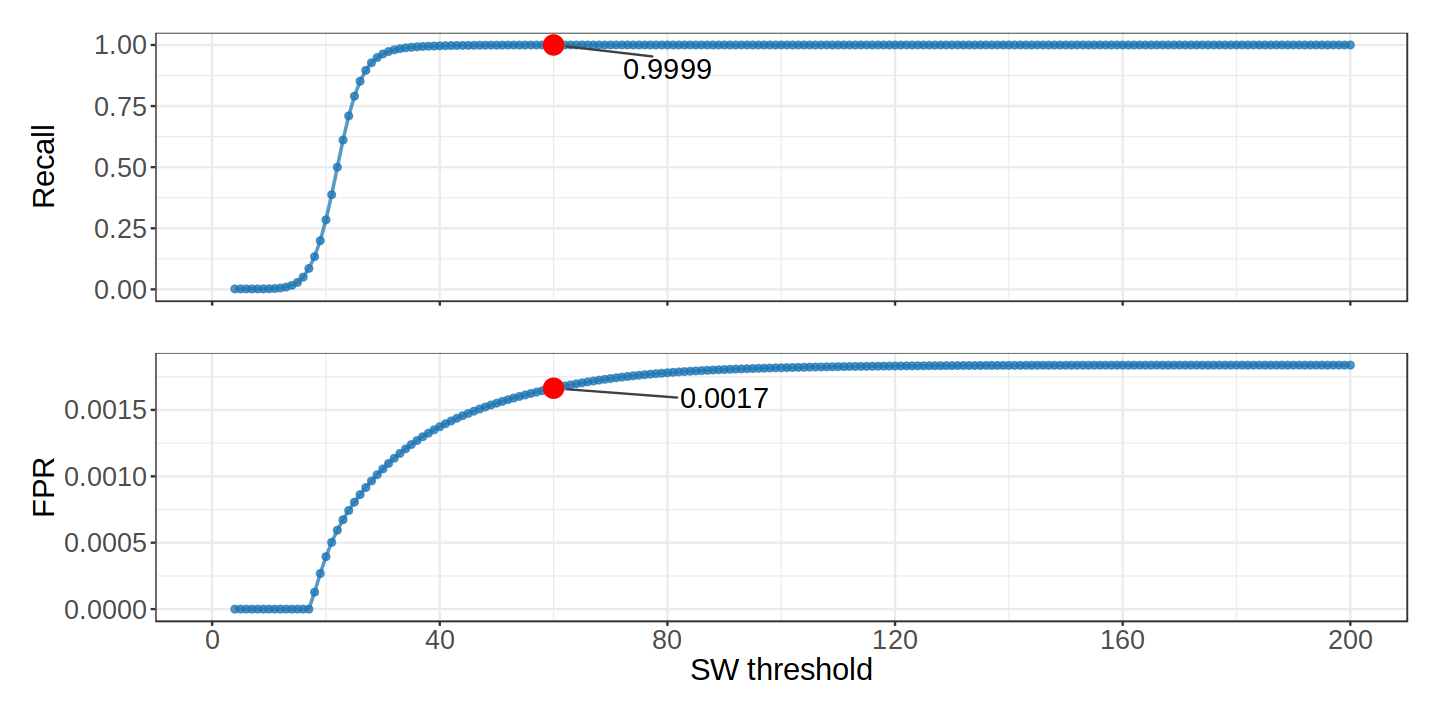

In [14]:
options(repr.plot.width=12,repr.plot.height=6)
p_2bc <- (p_2b / p_2c) + plot_layout(axis_titles ="collect")
p_2bc

# Runtime

In [15]:
runtime_df <- read.csv(runtime_path) %>%
    mutate(
        cpu_days = round(cpu_days,2),
        method = ifelse(word_size == -1,"naive",method)
    ) %>%
    filter(word_size==7 | word_size == -1)
head(runtime_df)
dim(runtime_df)

,dataset_size,word_size,cpu_time_tool,n_candidates,comparisons_factor,cpu_time_comparisons,cpu_time_total,cpu_days,method
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,200000,7,56769.9,0,0.000510846,0.00,56769.90,0.66,hashFrag-lightning
2,150000,7,34337.0,0,0.000510846,0.00,34337.00,0.40,hashFrag-lightning
3,100000,7,15072.1,0,0.000510846,0.00,15072.10,0.17,hashFrag-lightning
4,50000,7,5436.9,0,0.000510846,0.00,5436.90,0.06,hashFrag-lightning
5,200000,7,56769.9,95369046,0.000510846,48718.89,105488.79,1.22,hashFrag-pure
6,150000,7,34337.0,53531249,0.000510846,27346.22,61683.22,0.71,hashFrag-pure


[1] 12  9

In [16]:
runtime_df %>%
    filter(word_size == 7 | word_size == -1) %>%
    dplyr::select(dataset_size,method,cpu_days) %>%
    arrange(method,dataset_size) %>%
    pivot_wider(names_from=method,values_from=cpu_days) %>%
    mutate(
        lightning_over_naive = naive/`hashFrag-lightning`,
        pure_over_naive=naive/`hashFrag-pure`
    ) %>%
    summarize(mean_lon = mean(lightning_over_naive),mean_pon = mean(pure_over_naive))

mean_lon,mean_pon
<dbl>,<dbl>
160.6289,86.14368


In [17]:
p_2d <- ggplot(runtime_df,aes(x=dataset_size,y=cpu_days)) +
    geom_point(aes(color=method),size=3) +
    geom_line(aes(group=method,color=method)) +
    # geom_text_repel(aes(label=after_stat(y)),size=6,box.padding=1,nudge_y=0.1) +
    geom_text(aes(label=after_stat(y)),size=6,vjust=-0.5) +
    scale_y_log10(
        limits = c(.025,200),
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    scale_color_brewer(palette="Set2") +
    scale_x_continuous(limits=c(40000,210000),breaks=c(50000,100000,150000,200000),labels=c("50,000","100,000","150,000","200,000")) +
    annotation_logticks(sides="l") +
    theme_bw() + theme(
        panel.grid = element_blank(),
        legend.position  = c(0.65,0.125),
        strip.text       = element_text(color="black",size=16),
        strip.background = element_blank(),
        axis.text        = element_text(size=16),
        axis.text.x      = element_text(size=16,angle=90,vjust=0.5,hjust=1),
        axis.title       = element_text(size=18),
        legend.title     = element_blank(),
        legend.text      = element_text(size=18),
        legend.background = element_rect(fill='transparent',color=NA),
        legend.box.background = element_rect(fill='transparent',color=NA),
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin = unit(c(0.5,0.5,0.5,0.5),"cm")
    ) +
    labs(
        x="Number of sequences",
        y="CPU time (days)",
        # subtitle="Computing cost"
    )


Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


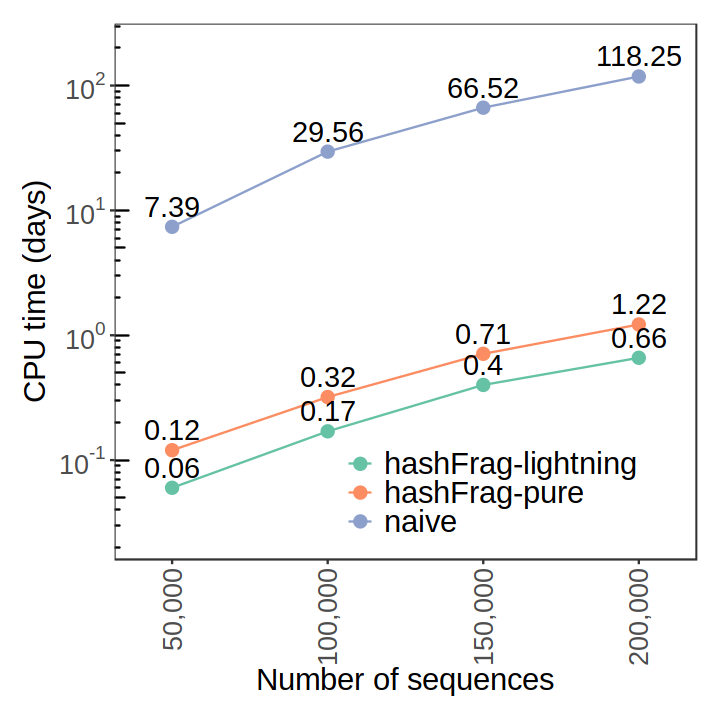

In [18]:
options(repr.plot.width=6,repr.plot.height=6)
p_2d

In [19]:
max_blast_scores_df <- read.csv(max_blast_scores_path,header=F) %>%
    dplyr::rename(sw=V1) %>%
    mutate(method="hashFrag splits")
max_chrom_scores_df <- read.csv(max_chrom_scores_path,header=F) %>%
    dplyr::rename(sw=V1) %>%
    mutate(method="Chromosomal splits")
max_scores_df <- rbind(max_blast_scores_df,max_chrom_scores_df)
head(max_scores_df)
dim(max_scores_df)

,sw,method
,<dbl>,<chr>
1,31,hashFrag splits
2,32,hashFrag splits
3,30,hashFrag splits
4,31,hashFrag splits
5,31,hashFrag splits
6,30,hashFrag splits


[1] 91146     2

In [20]:
min(max_scores_df$sw)

[1] 23

In [21]:
colors <- c("Chromosomal splits"="dodgerblue3","hashFrag splits"="firebrick1")
p_2e <- max_scores_df %>%
    group_by(sw,method) %>%
    summarize(count_max_sw = n()) %>%
    ggplot() +
    geom_bar(data = . %>% filter(method == "Chromosomal splits"),mapping=aes(x=sw,y=count_max_sw,fill="Chromosomal splits"),stat="identity",color="dodgerblue3",alpha=0.6,linewidth=0.25) +
    geom_bar(data = . %>% filter(method == "hashFrag splits"),mapping=aes(x=sw,y=count_max_sw,fill="hashFrag splits"),stat="identity",color="firebrick1",alpha=0.8,linewidth=0.25) +
    scale_fill_manual(values=colors)  +
    scale_x_continuous(limits=c(20,200),breaks=seq(20,200,20)) +
    scale_y_log10(
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    annotation_logticks(sides="l") +
    labs(
        x = "Maximum pairwise SW alignment score",
        y = "Frequency (log scale)"
    ) +
    theme_bw() + theme(
        panel.grid = element_blank(),
        legend.position = c(0.7,0.85),
        strip.text = element_text(color="black"),
        strip.background = element_blank(),
        axis.text        = element_text(size=16),
        axis.title       = element_text(size=18),
        legend.title     = element_blank(),
        legend.text      = element_text(size=18),
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin = unit(c(0.5,0.5,0.5,0.5),"cm")
    )
        

`summarise()` has grouped output by 'sw'. You can override using the `.groups` argument.


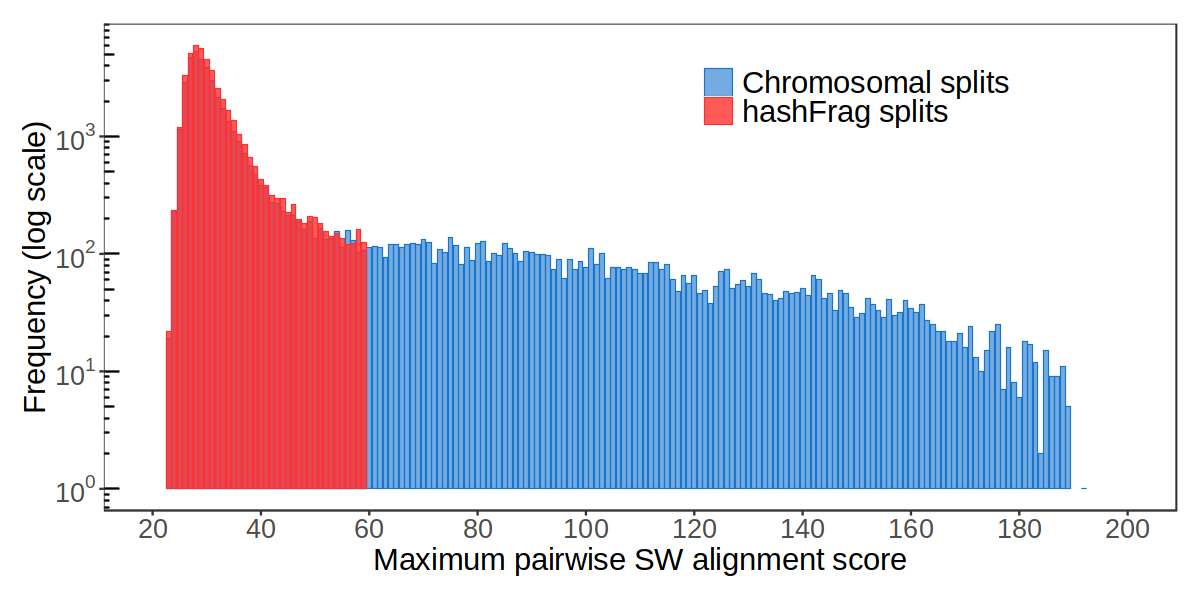

In [22]:
options(repr.plot.width=10,repr.plot.height=5)
p_2e

In [23]:
test_df <- read.csv(model_performance_path)

In [24]:
model_performance_df <- read.csv(model_performance_path) %>%
    mutate(
        Seq_Type = sub("chromosomal_gosai","Chromosomal",Seq_Type),
        Seq_Type = sub("hashFrag_gosai","hashFrag",Seq_Type)
    )

head(model_performance_df)
dim(model_performance_df)

strat_performance_df <- read.csv(strat_performance_path)

head(strat_performance_df)
dim(strat_performance_df)
# best_epoch_df <- read.csv(best_epoch_path) %>%
#     mutate(
#         Condition = sub("chromosomal_new","Chromosomal",Condition),
#         Condition = sub("HomoTrainOrthoVal","hashFrag",Condition)
#     )
# head(best_epoch_df)
# dim(best_epoch_df)

,Correlation,Seq_Type,Rep,Fold
,<dbl>,<chr>,<int>,<int>
1,0.2597774,Chromosomal,1,1
2,0.2745318,Chromosomal,2,1
3,0.2580655,Chromosomal,3,1
4,0.2714072,Chromosomal,4,1
5,0.2800395,Chromosomal,5,1
6,0.2732797,Chromosomal,6,1


[1] 200   4

,X,Chromosomal.Split,Model,Threshold,Performance,Length
,<int>,<chr>,<chr>,<int>,<dbl>,<int>
1,0,smith_waterman0,DREAM-CNN,30,0.4625684,112900
2,1,smith_waterman0,DREAM-CNN,40,0.4849347,133962
3,2,smith_waterman0,DREAM-CNN,50,0.4866333,140148
4,3,smith_waterman0,DREAM-CNN,60,0.4858802,144500
5,4,smith_waterman0,DREAM-CNN,70,0.4852388,148147
6,5,smith_waterman0,DREAM-CNN,80,0.4840057,151582


[1] 216   6

In [25]:
p_2f <- ggplot(strat_performance_df,aes(x=factor(Threshold),y=Performance)) +
    geom_bar(stat="summary",fun="mean",fill="#1f77b4",color="#1f77b4",width=0.75) +
    coord_cartesian(ylim=c(0.445,0.49)) +
    scale_x_discrete(limits=rev,labels=c("200","190","180","170","160","150","140","130","120","110","100","90","80","70",expression(bold("60")),"50","40","30")) +
    theme_bw() + theme(
        panel.grid       = element_blank(),
        strip.text       = element_text(color="black",size=18),
        strip.background = element_blank(),
        axis.text        = element_text(size=16),
        axis.text.x      = element_text(size=16,angle=90,hjust=1,vjust=0.5),
        axis.title       = element_text(size=18),
        legend.position  = "none",
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin      = unit(c(1,0.25,1,0.5),"cm"),
        plot.title = element_text(size=18,hjust=0.5)
    ) +
    labs(x = "SW threshold",y=expression(paste("Pearson ", "r"^2)))

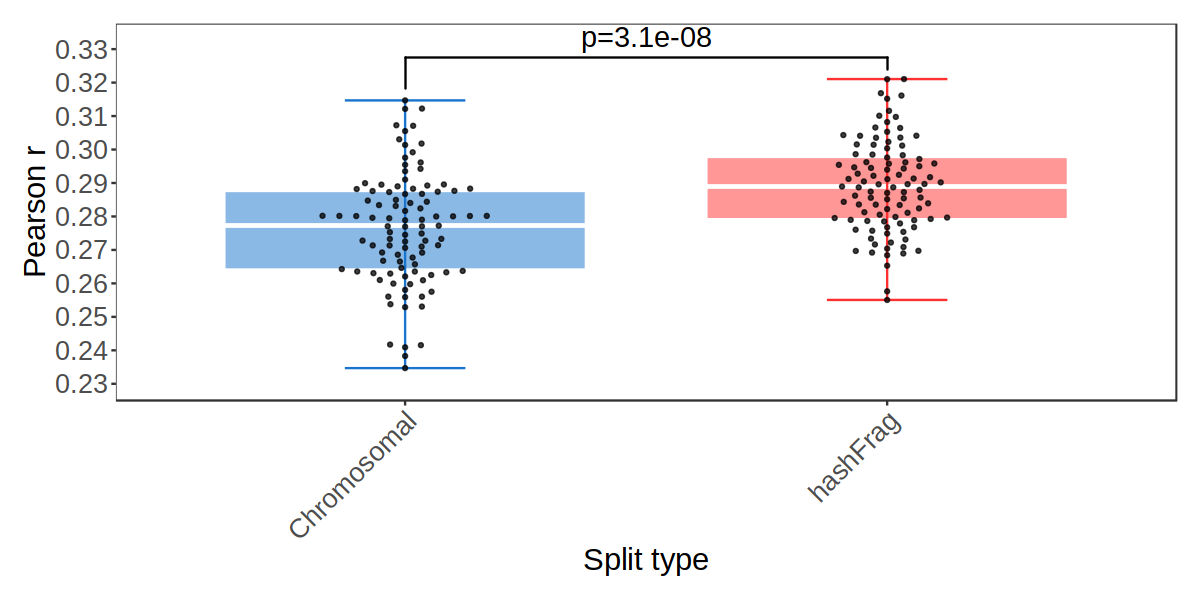

In [26]:
p_2g <- model_performance_df %>%
    # ggplot(aes(x=Seq_Type,y=Correlation^2)) +
    ggplot(aes(x=Seq_Type,y=Correlation)) +
    geom_boxplot(aes(color=Seq_Type,fill=Seq_Type),alpha=0.5,color="white",outliers=T,outlier.color="black",outlier.shape=3,outlier.size=2.5,outlier.stroke=1) +
    stat_boxplot(aes(color=Seq_Type),geom ='errorbar',width=0.25) +
    geom_beeswarm(cex=1.75,size=0.75,alpha=0.75) +
    scale_color_manual(values=c("dodgerblue3","firebrick1")) +
    scale_fill_manual(values=c("dodgerblue3","firebrick1")) +
    scale_y_continuous(limits=c(0.23,0.3325),breaks=seq(0.23,0.33,0.01)) +
    labs(
        x = "Split type",
        # y = expression(paste("Pearson ", "r"^2))
        y = "Pearson r"
    ) +
    geom_bracket(
        xmin = "Chromosomal", xmax = "hashFrag", y.position = 0.3275,
        label = "p=3.1e-08", 
        tip.length = c(0.1, 0.04),vjust=-0.35,
        size=0.5,
        label.size = 6
    ) +
    theme_bw() + theme(
        panel.grid = element_blank(),
        legend.position = "none",
        axis.text        = element_text(size=16),
        axis.text.x        = element_text(size=16,angle=45,hjust=1,vjust=1),
        axis.title       = element_text(size=18),
        legend.title     = element_blank(),
        legend.text      = element_text(size=16),
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin      = unit(c(0.5,0.5,0.5,0.5),"cm"),
        plot.title = element_text(size=18,hjust=0.5)
    )
p_2g

In [27]:
# p_2g <- best_epoch_df %>%
#     ggplot(aes(x=Condition,y=Best_Epoch)) +
#     geom_boxplot(aes(color=Condition,fill=Condition),alpha=0.5,color="white",outliers=T,outlier.color="black",outlier.shape=3,outlier.size=2.5,outlier.stroke=1) +
#     stat_boxplot(aes(color=Condition),geom ='errorbar',width=0.25) +
#     geom_beeswarm(cex=1.85,size=0.75,alpha=0.75) +
#     scale_color_manual(values=c("dodgerblue3","firebrick1")) +
#     scale_fill_manual(values=c("dodgerblue3","firebrick1")) +
#     scale_y_continuous(limits=c(50,85),breaks=seq(50,85,5)) +
#     labs(
#         x = "Split type",
#         y = "Best epoch\nbased on validation score"
#     ) +
#     geom_bracket(
#         xmin = "Chromosomal", xmax = "hashFrag", y.position = 82,
#         label = "p=1.6e-03", 
#         tip.length = c(0.01,0.03),vjust=-0.35,
#         size=0.5,
#         label.size = 6
#     ) +
#     theme_bw() + theme(
#         panel.grid = element_blank(),
#         legend.position  = "none",
#         axis.text        = element_text(size=16),
#         axis.text.x      = element_text(size=16,angle=45,hjust=1,vjust=1),
#         axis.title       = element_text(size=18),
#         legend.title     = element_blank(),
#         legend.text      = element_text(size=16),
#         plot.subtitle    = element_text(size=18,hjust=0.5),
#         plot.margin      = unit(c(0.5,0.5,0.5,0.5),"cm"),
#         plot.title = element_text(size=18,hjust=0.5)
#     )

In [41]:
library(ggnewscale)

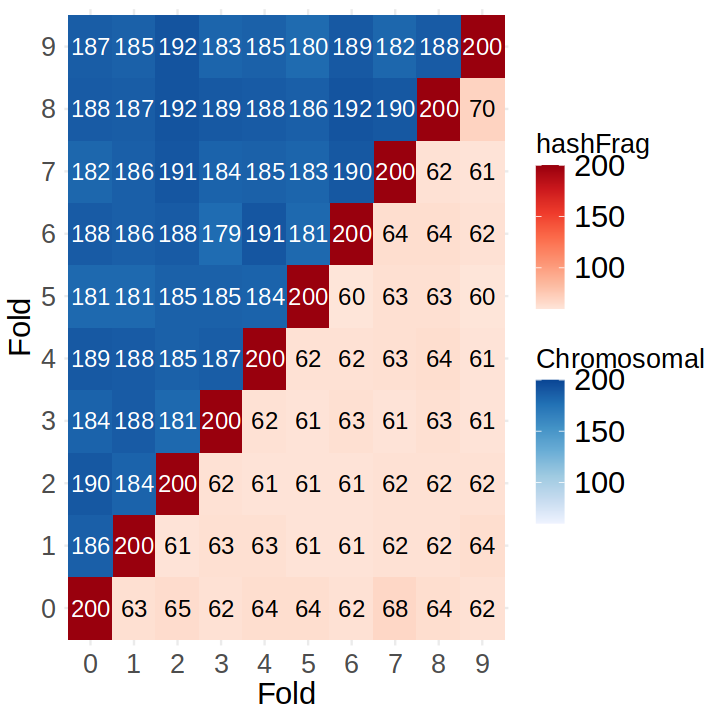

In [68]:
options(repr.plot.width=6,repr.plot.height=6)
cross_fold_df <- read.csv(cross_fold_sw_path)
p_2h <- ggplot(cross_fold_df,aes(x=factor(fold_i),y=factor(fold_j))) +
    geom_tile(
        data = . %>% filter(condition=="hashFrag folds"),
        mapping = aes(fill=max_sw_score)
    ) +
    scale_fill_distiller(palette="Reds",limits=c(60,200),name="hashFrag",direction=1) +
    new_scale_fill() +
    geom_tile(
        data = . %>% filter(condition == "Chromosomal folds"),
        mapping = aes(fill=max_sw_score)
    ) +
    scale_fill_distiller(palette="Blues",limits=c(60,200),name="Chromosomal",direction=1) +
    # geom_text(aes(label=round(max_sw_score)), color="black", size=3) +  # overlay values
    geom_text(
        aes(
          label = round(max_sw_score),
          color = max_sw_score <= 150  # logical, TRUE = one color, FALSE = another
        ),
        size = 5
    ) +
    labs(
        x = "Fold",
        y = "Fold"
    ) +
    scale_color_manual(values=c("white","black"), guide="none") + 
    theme_minimal() +
    theme(
        # aspect.ratio = 1,
        axis.title = element_text(size=18),
        axis.text = element_text(size=16),
        legend.text = element_text(size=18),
        legend.title =element_text(size=16)
    )
p_2h

In [69]:
p2_top <- (p_2bc | p_2d | p_2e) + plot_layout(widths=c(0.75,1,1.5))
# p2_top

In [70]:
p2_bot <- (p_2f | p_2g | p_2h) + plot_layout(widths = c(1.25,0.5,1))
# p2_bot

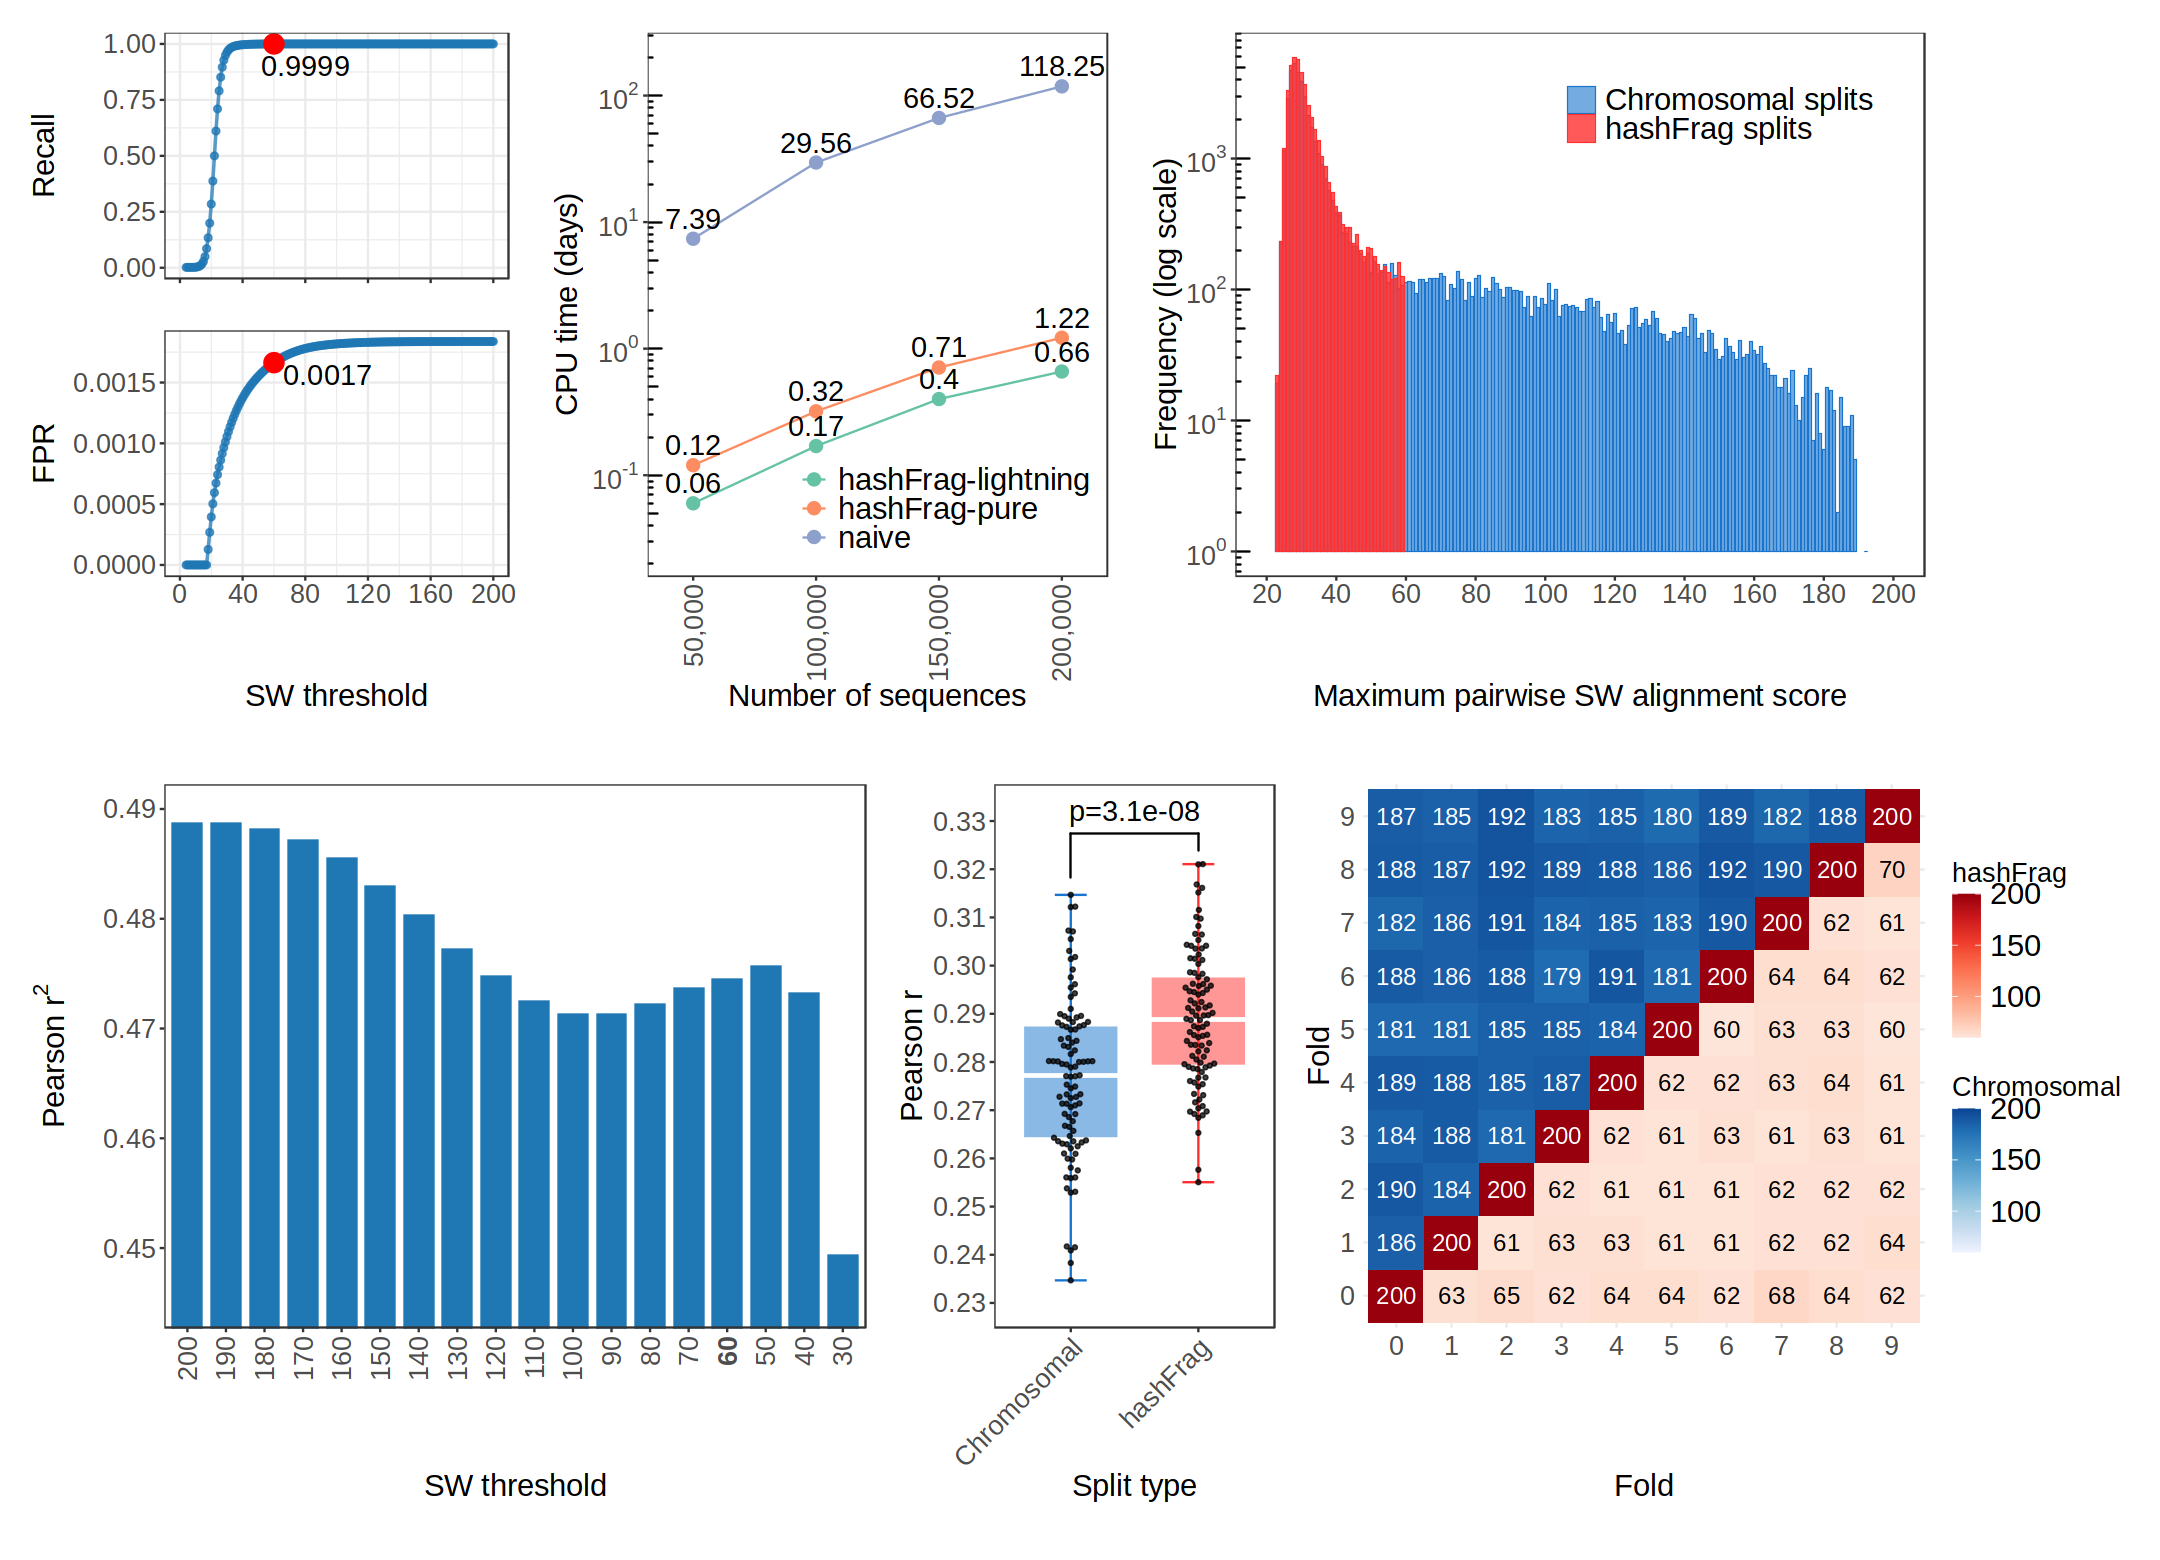

In [71]:
options(repr.plot.width=18,repr.plot.height=13)
p_2 <- p2_top / p2_bot
outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.fig2.tiff"
ggsave(outpath,plot=p_2,width=18,height=13,dpi="retina")
outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.fig2.svg"
ggsave(outpath,plot=p_2,width=18,height=13,dpi="retina")
p_2

# Number of candidates before and after filtering by actual SW

In [29]:
path <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/hashFrag.blastn.n_candidates.before_after_filtering.csv.gz"
candidates_df <- read.csv(path) %>%
    pivot_wider(names_from="Type",values_from="n_candidates") %>%
    dplyr::rename(filtered = `filtered candidates (SW >= 60)`) %>%
    mutate(filtered = ifelse(is.na(filtered),0,filtered)) %>%
    pivot_longer(cols=c("candidates","filtered"),names_to="Type",values_to="n_candidates") %>%
    mutate(
        Type = sub("filtered","Filtered (SW >= 60)",Type),
        Type = sub("candidates","Unfiltered",Type),
        Type = factor(Type,levels=c("Unfiltered","Filtered (SW >= 60)"))
    )

# candidates_df$seq_id <- factor(candidates_df$seq_id,levels=candidates_df$seq_id)

head(candidates_df)
dim(candidates_df)


seq_id,Type,n_candidates
<chr>,<fct>,<dbl>
peak10,Unfiltered,37
peak10,Filtered (SW >= 60),2
peak1000,Unfiltered,121
peak1000,Filtered (SW >= 60),18
peak10000,Unfiltered,170
peak10000,Filtered (SW >= 60),1


[1] 452506      3

In [30]:
options(repr.plot.width=10,repr.plot.height=5)
p <- ggplot(candidates_df,aes(x=n_candidates,fill=Type)) +
    geom_histogram(bins=250,position="identity",linewidth=0.05,color="black",alpha=0.75) +
    scale_y_log10(
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x)),
        expand = expansion(mult = c(0,.05))
    ) +
    scale_fill_manual(values=c("dodgerblue3","coral")) +
    annotation_logticks(sides="l") +
    theme_bw() + theme(
        panel.grid = element_blank(),
        legend.position  = c(0.75,0.85),
        axis.text        = element_text(size=16),
        axis.title       = element_text(size=18),
        legend.title     = element_blank(),
        legend.text      = element_text(size=16),
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin      = unit(c(0.5,0.5,0.5,0.5),"cm"),
        plot.title = element_text(size=18,hjust=0.5)
    ) +
    labs(x = "Number of candidates", y = "Number of sequences")

outpath <- ""
ggsave(outpath,plot=p,width=10,height=5,dpi="retina")

outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.n_candidates_before_after_filtering.png"
ggsave(outpath,plot=p,width=10,height=5,dpi="retina")


Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
“log-10 transformation introduced infinite values.”


Warning message in scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), :
“log-10 transformation introduced infinite values.”


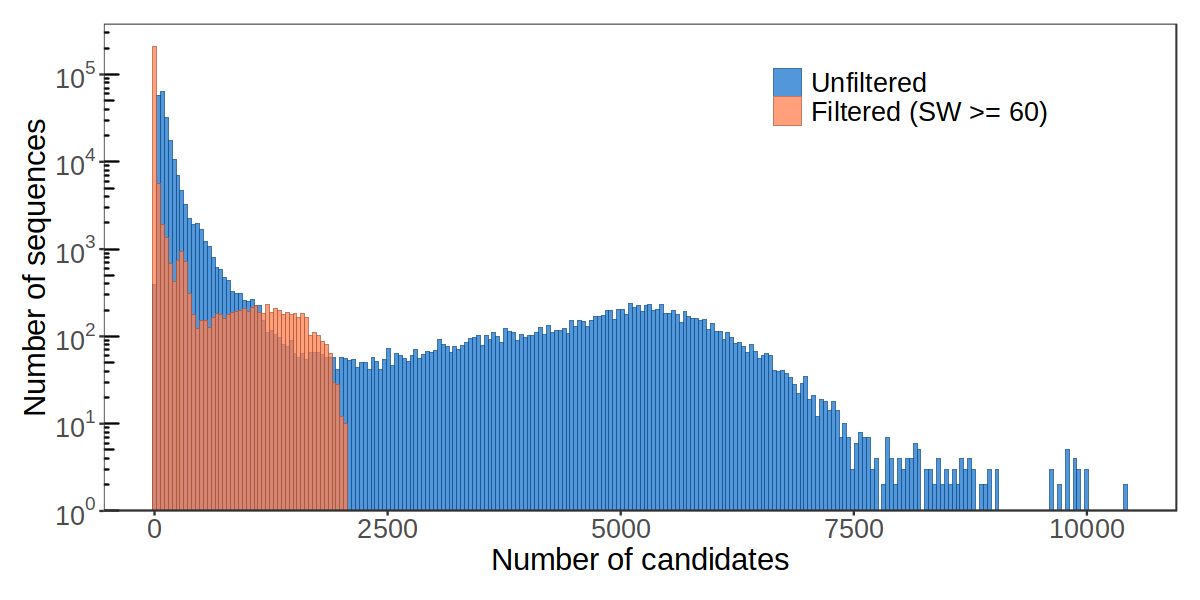

In [31]:
p

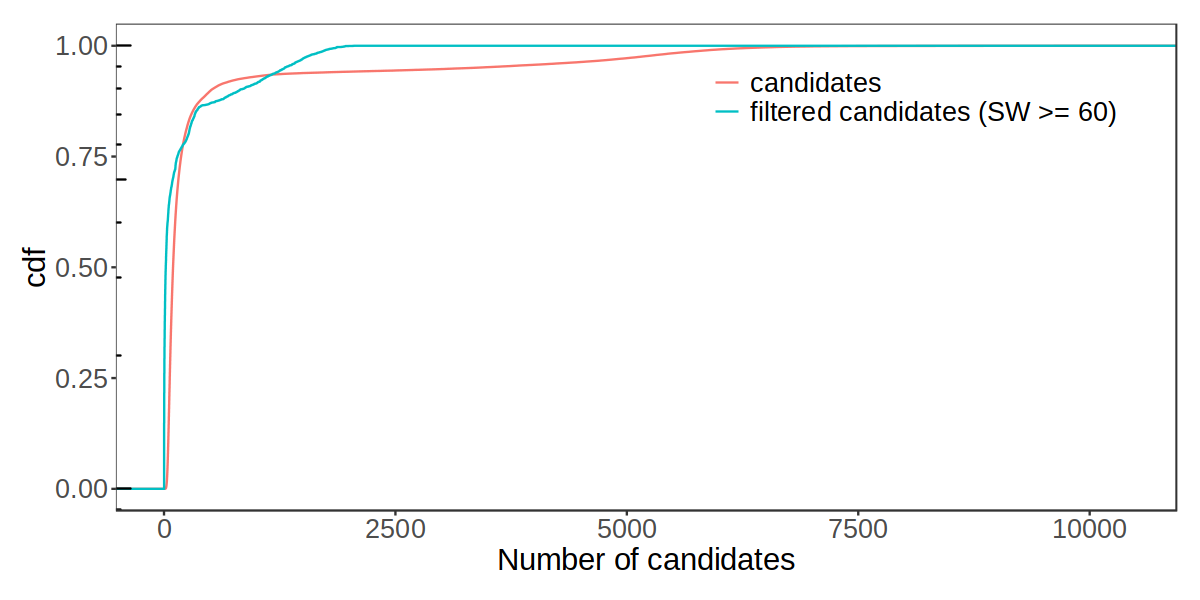

In [16]:
options(repr.plot.width=10,repr.plot.height=5)
ggplot(candidates_df,aes(x=n_candidates,fill=Type,color=Type)) +
    stat_ecdf() +
    # geom_histogram(bins=250,position="identity",linewidth=0.05,color="black",alpha=0.9) +
    # scale_y_log10(
    #     breaks = trans_breaks("log10", function(x) 10^x),
    #     labels = trans_format("log10", math_format(10^.x)),
    #     expand = expansion(mult = c(0,.05))
    # ) +
    scale_fill_manual(values=c("dodgerblue3","coral")) +
    annotation_logticks(sides="l") +
    theme_bw() + theme(
        panel.grid = element_blank(),
        legend.position  = c(0.75,0.85),
        axis.text        = element_text(size=16),
        axis.title       = element_text(size=18),
        legend.title     = element_blank(),
        legend.text      = element_text(size=16),
        plot.subtitle    = element_text(size=18,hjust=0.5),
        plot.margin      = unit(c(0.5,0.5,0.5,0.5),"cm"),
        plot.title = element_text(size=18,hjust=0.5)
    ) +
    labs(x = "Number of candidates", y = "cdf")

# outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.n_candidates_before_after_filtering.tiff"
# ggsave(outpath,plot=p,width=10,height=5,dpi="retina")

# outpath <- "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/hashFrag_figs/hashFrag.n_candidates_before_after_filtering.png"
# ggsave(outpath,plot=p,width=10,height=5,dpi="retina")


In [54]:
options(repr.plot.width=20,repr.plot.height=6)
p_bot <- df %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(recall = mean(recall)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; ")
    ) %>%
    ggplot(aes(x=threshold,y=recall)) +
    geom_line(aes(color=label),linewidth=0.25,alpha=0.5) +
    geom_point(aes(color=label),size=0.25) +
    scale_color_brewer(palette="Set2") +
    facet_wrap(~word_size,nrow=1,scale="free_y") +
    theme_classic() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = "bottom",
        strip.background = element_blank(),
        strip.text = element_blank()
    ) +
    guides(color = guide_legend(override.aes = list(size = 3) ) )

`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can override using the `.groups`
argument.


In [120]:
options(repr.plot.width=20,repr.plot.height=6)
p_top <- df %>%
    group_by(threshold,word_size,e_value,dust) %>%
    summarize(recall = mean(recall)) %>%
    mutate(
        dust = ifelse(dust,"Dust: yes","Dust: no"),
        e_value = paste0("e-value: ",e_value),
        label = paste(e_value,dust,sep="; ")
    ) %>%
    ggplot(aes(x=threshold,y=recall)) +
    geom_line(aes(color=label),linewidth=0.25,alpha=0.5) +
    geom_point(aes(color=label),size=0.5) +
    scale_color_brewer(palette="Set2") +
    facet_wrap(~word_size,nrow=1,scales="free_y") +
    theme_bw() + theme(
        panel.grid.minor = element_blank(),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16),
        axis.title.x = element_blank(),
        legend.text = element_text(size=14),
        legend.title = element_text(size=16),
        legend.position = "none"
    ) +
    guides(color = guide_legend(override.aes = list(size = 3) ) ) +
    coord_cartesian(ylim=c(0.9,1),xlim=c(25,160))

`summarise()` has grouped output by 'threshold', 'word_size', 'e_value'. You can
override using the `.groups` argument.


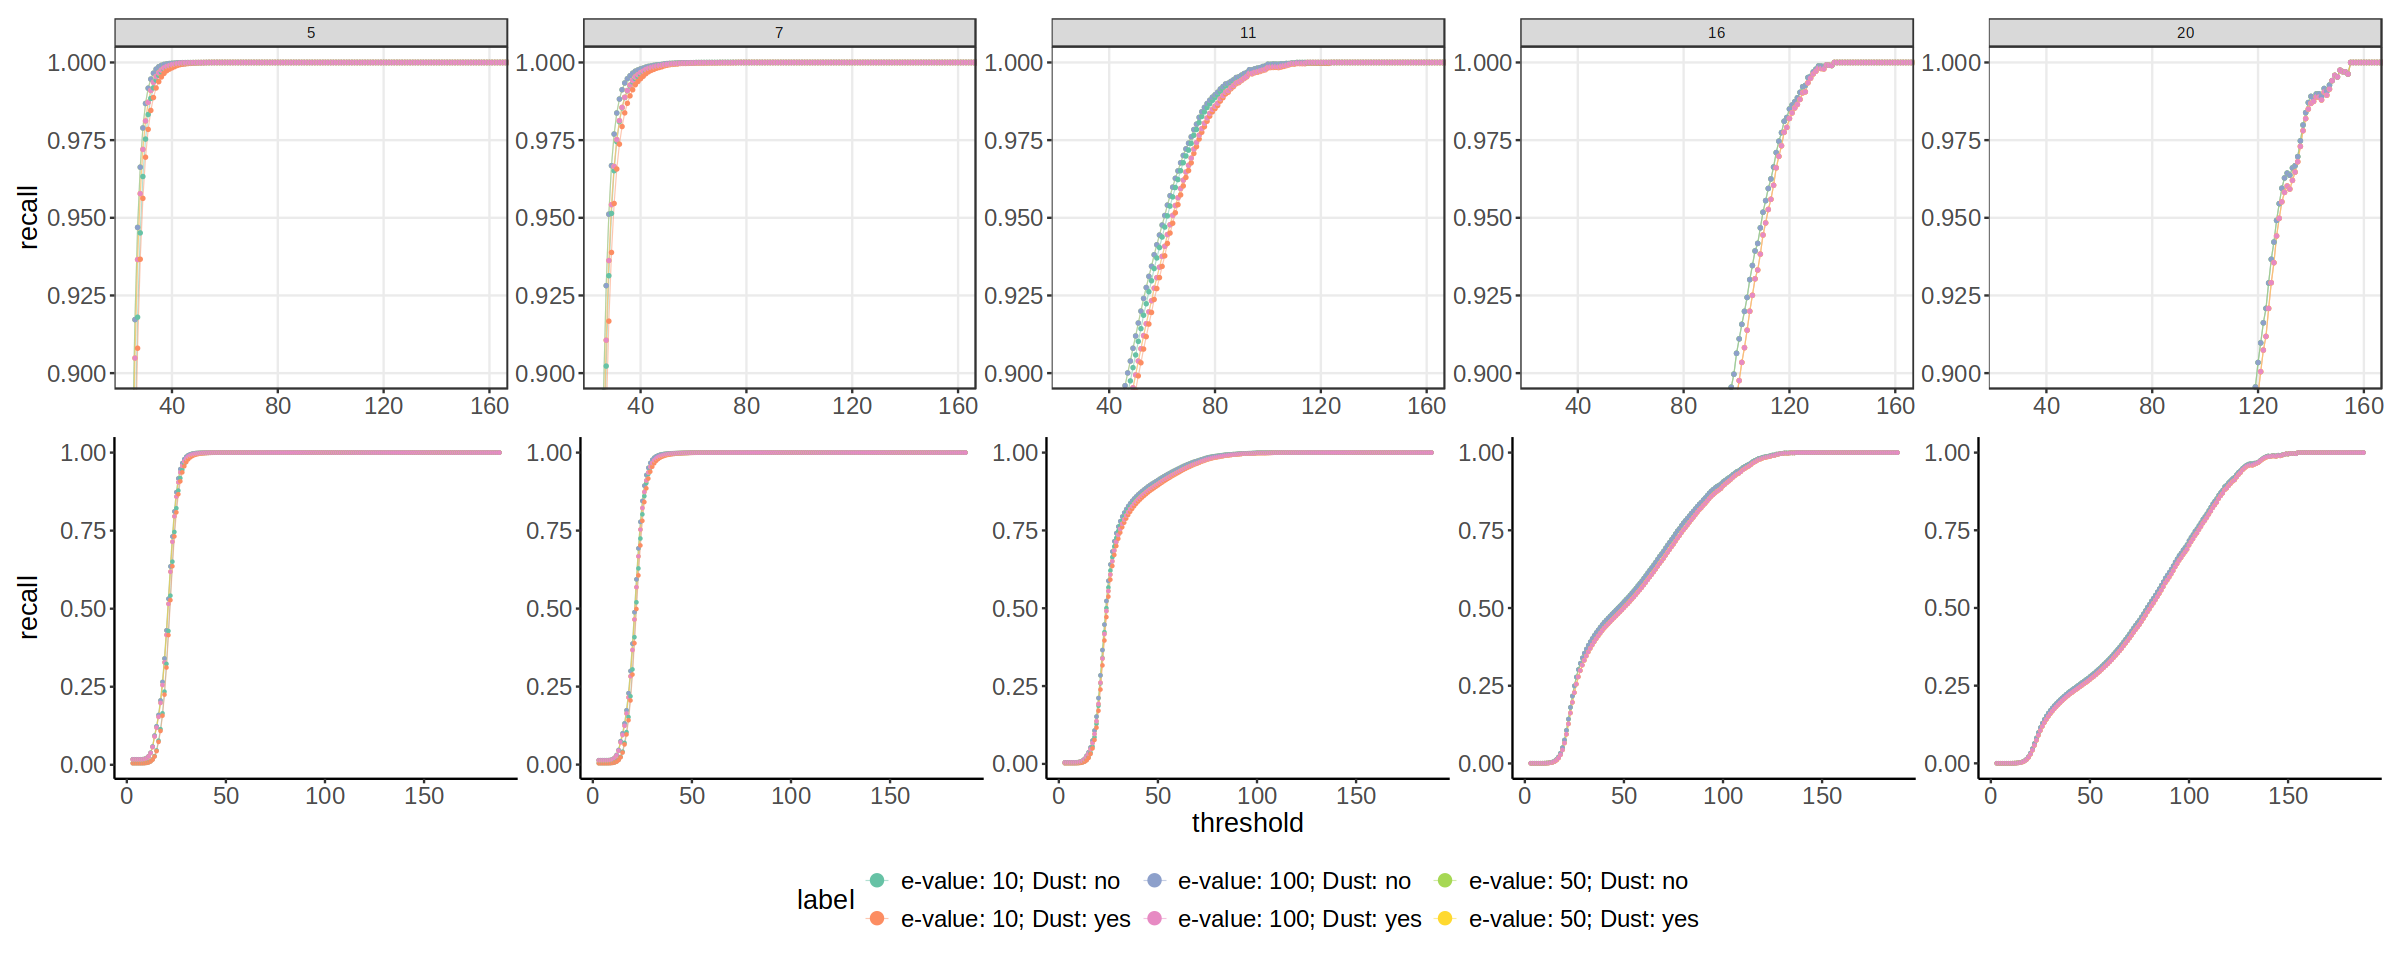

In [123]:
options(repr.plot.width=20,repr.plot.height=8)
p_top / p_bot

In [101]:
processed_df <- df %>%
    separate(file_label,into=c("dataset","subsample","word_size","max_target_seqs","e_value","dust"),sep="\\.") %>%
    mutate(
        subsample = as.integer(sub("subsample_","",subsample)),
        word_size = as.integer(sub("wordsize_","",word_size)),
        max_target_seqs = as.integer(sub("maxtargetseqs_","",max_target_seqs)),
        e_value = as.integer(sub("evalue_","",e_value)),
        dust = dust == "dust_yes"
    ) %>%
    group_by(word_size,max_target_seqs,e_value,dust,threshold) %>%
    summarize(
        avg_recall = mean(recall),
        avg_fpr = mean(FPR),
    ) %>%
    ungroup()
head(processed_df)
dim(processed_df)

ERROR: [1m[33mError[39m in `separate()`:[22m
[1mCaused by error:[22m
[33m![39m object 'file_label' not found


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr
1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always
  returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'word_size', 'threshold'. You can override using the
`.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr
1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always
  returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'word_size', 'threshold'. You can override using the
`.groups` argument.


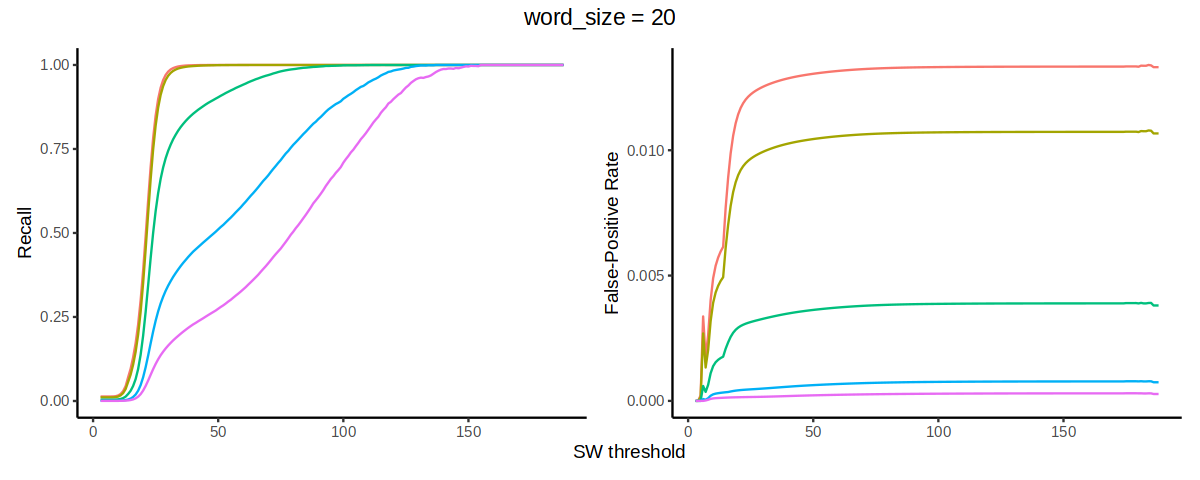

In [7]:
options(repr.plot.width=10,repr.plot.height=4)

p_recall <- processed_df %>%
    group_by(word_size,threshold) %>%
    summarize(
        avg_recall = mean(avg_recall),
        word_size = factor(word_size)
    ) %>%
    ggplot(aes(x=threshold,y=avg_recall,color=word_size,group=word_size)) +
    geom_line(linewidth=0.5,alpha=1) +
    labs(x = "SW threshold",y="Recall") +
    theme_classic() + theme(
        legend.position = "none",
        plot.title = element_text(hjust=0.5),
    )

p_fpr <- processed_df %>%
    group_by(word_size,threshold) %>%
    summarize(
        avg_fpr = mean(avg_fpr),
        word_size = factor(word_size)
    ) %>%
    ggplot(aes(x=threshold,y=avg_fpr,color=word_size,group=word_size)) +
    geom_line(linewidth=0.5,alpha=1) +
    labs(x = "SW threshold",y="False-Positive Rate") +
    theme_classic() + theme(
        legend.position = "none"
    )
p <- (p_recall | p_fpr) +
    plot_annotation(
        paste0("word_size = ",w),
        theme = theme(
            plot.title = element_text(hjust=0.5)
        )
    ) +
    plot_layout(axis_titles ="collect")

print(p)

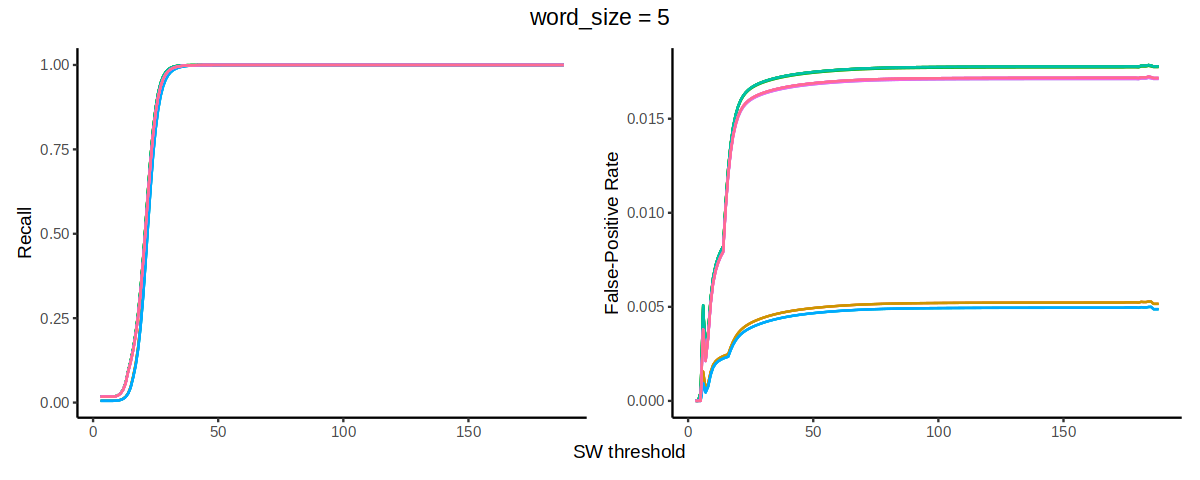

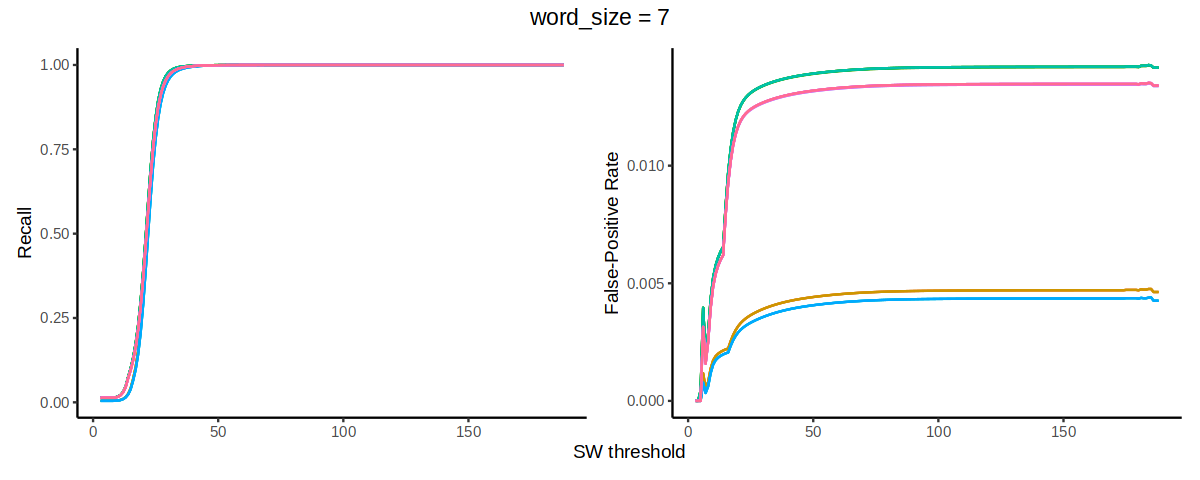

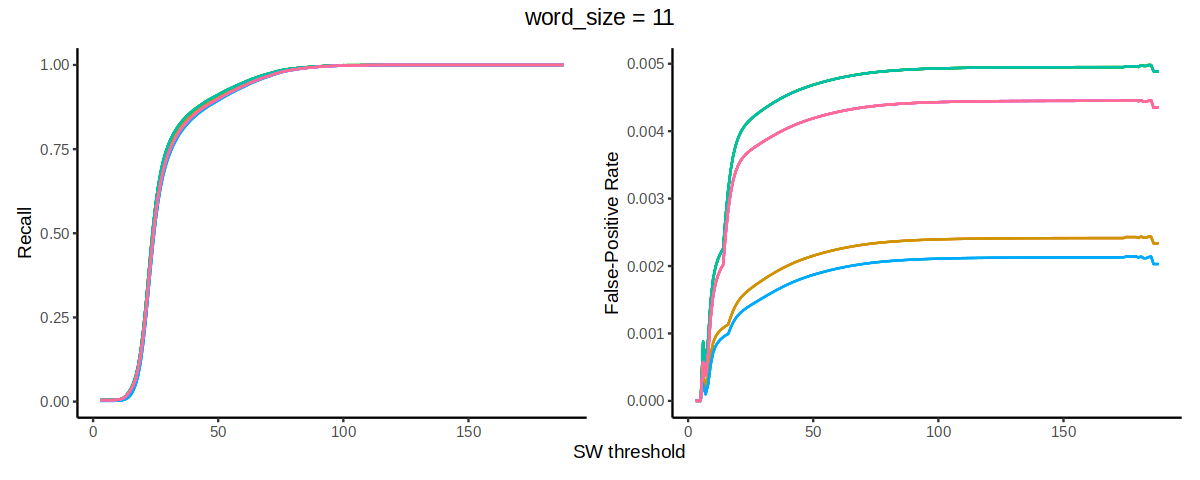

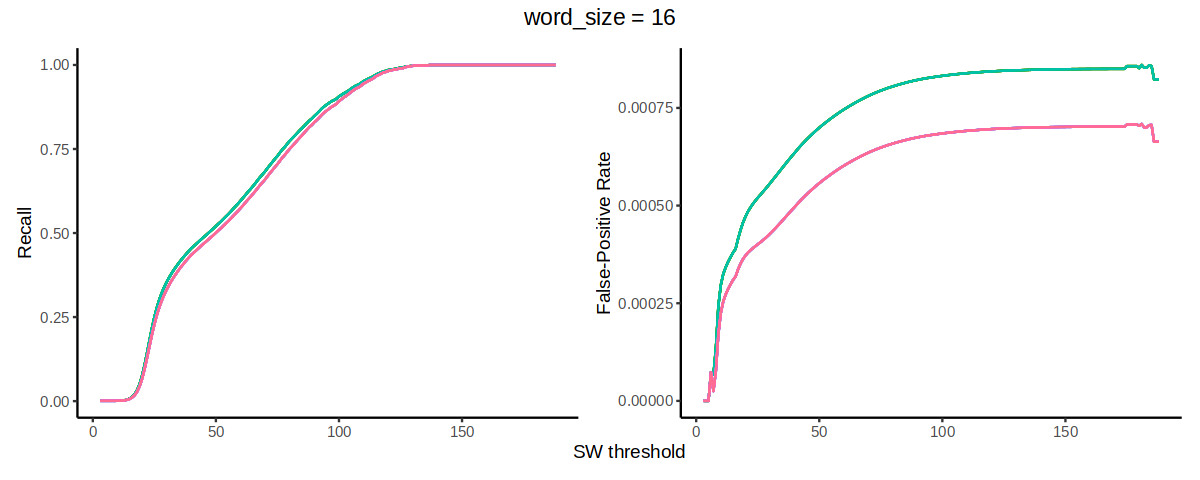

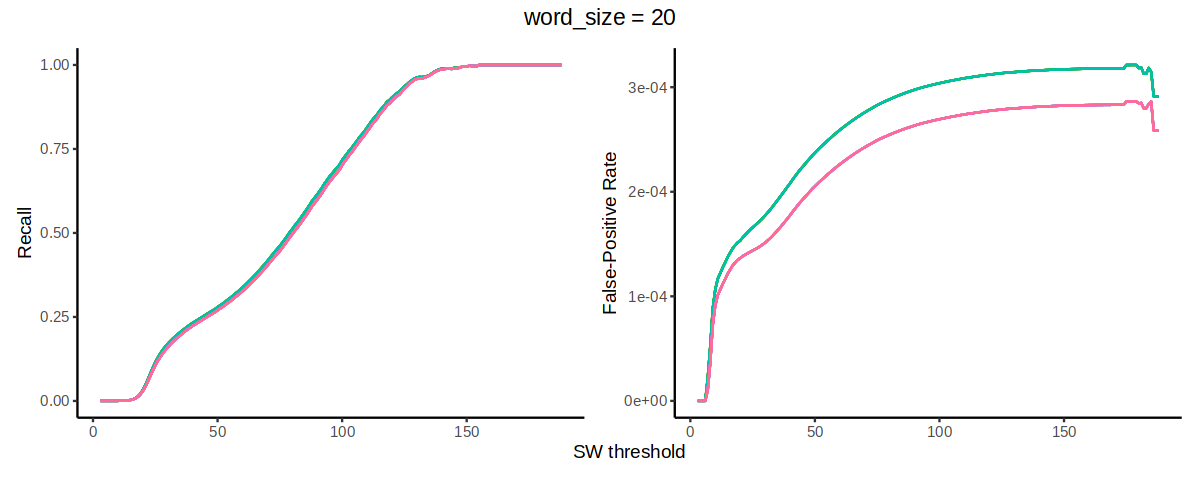

In [5]:
options(repr.plot.width=10,repr.plot.height=4)
for (w in unique(processed_df$word_size)) {
    p_recall <- processed_df %>%
        filter(word_size == w) %>%
        ggplot(aes(x=threshold,y=avg_recall,color=interaction(max_target_seqs,e_value,dust),group=interaction(max_target_seqs,e_value,dust))) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(x = "SW threshold",y="Recall") +
        theme_classic() + theme(
            legend.position = "none",
            plot.title = element_text(hjust=0.5),
        )

    p_fpr <- processed_df %>%
        filter(word_size == w) %>%
        ggplot(aes(x=threshold,y=avg_fpr,color=interaction(max_target_seqs,e_value,dust),interaction(max_target_seqs,e_value,dust))) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(x = "SW threshold",y="False-Positive Rate") +
        theme_classic() + theme(
            legend.position = "none"
        )
    p <- (p_recall | p_fpr) +
        plot_annotation(
            paste0("word_size = ",w),
            theme = theme(
                plot.title = element_text(hjust=0.5)
            )
        ) +
        plot_layout(axis_titles ="collect")
    print(p)
}

`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can 

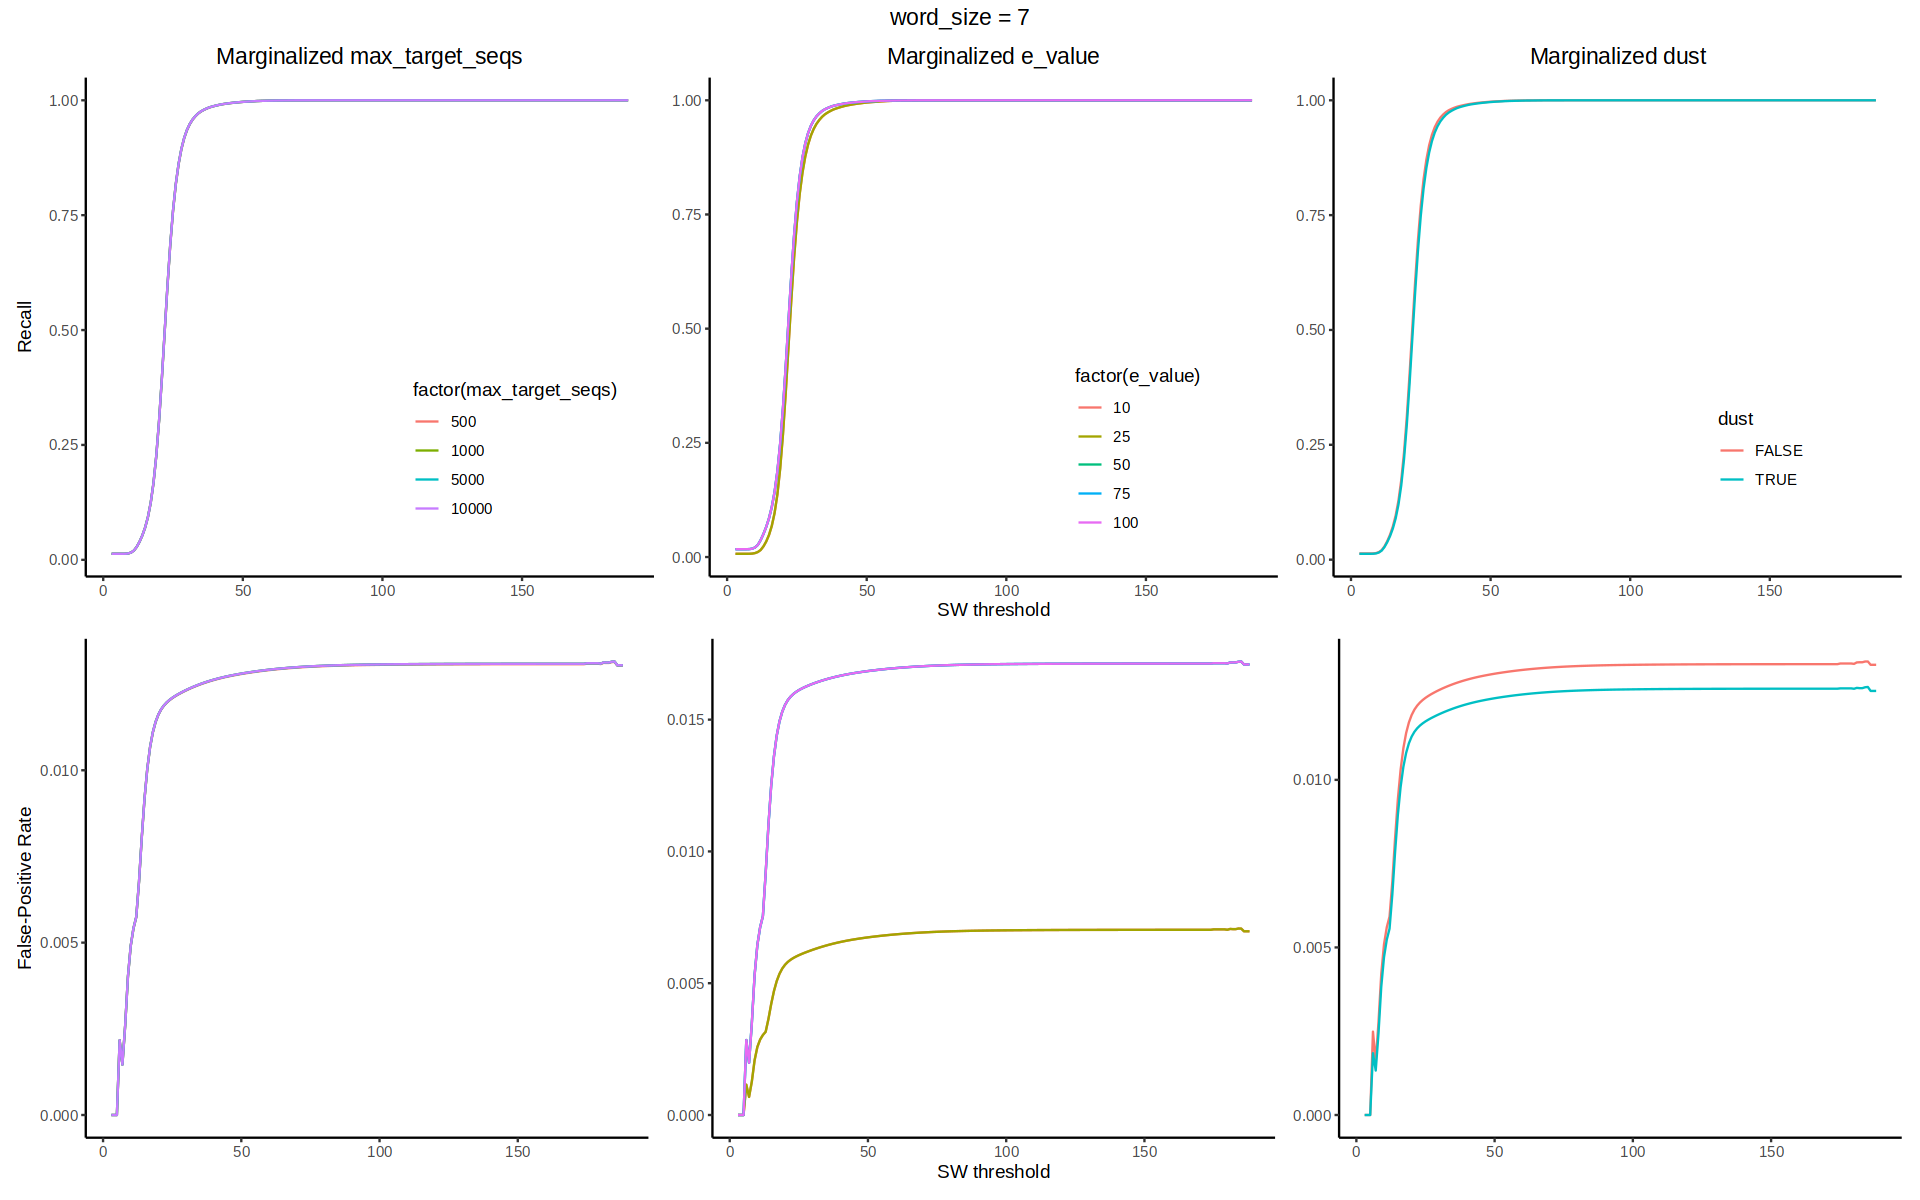

`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.


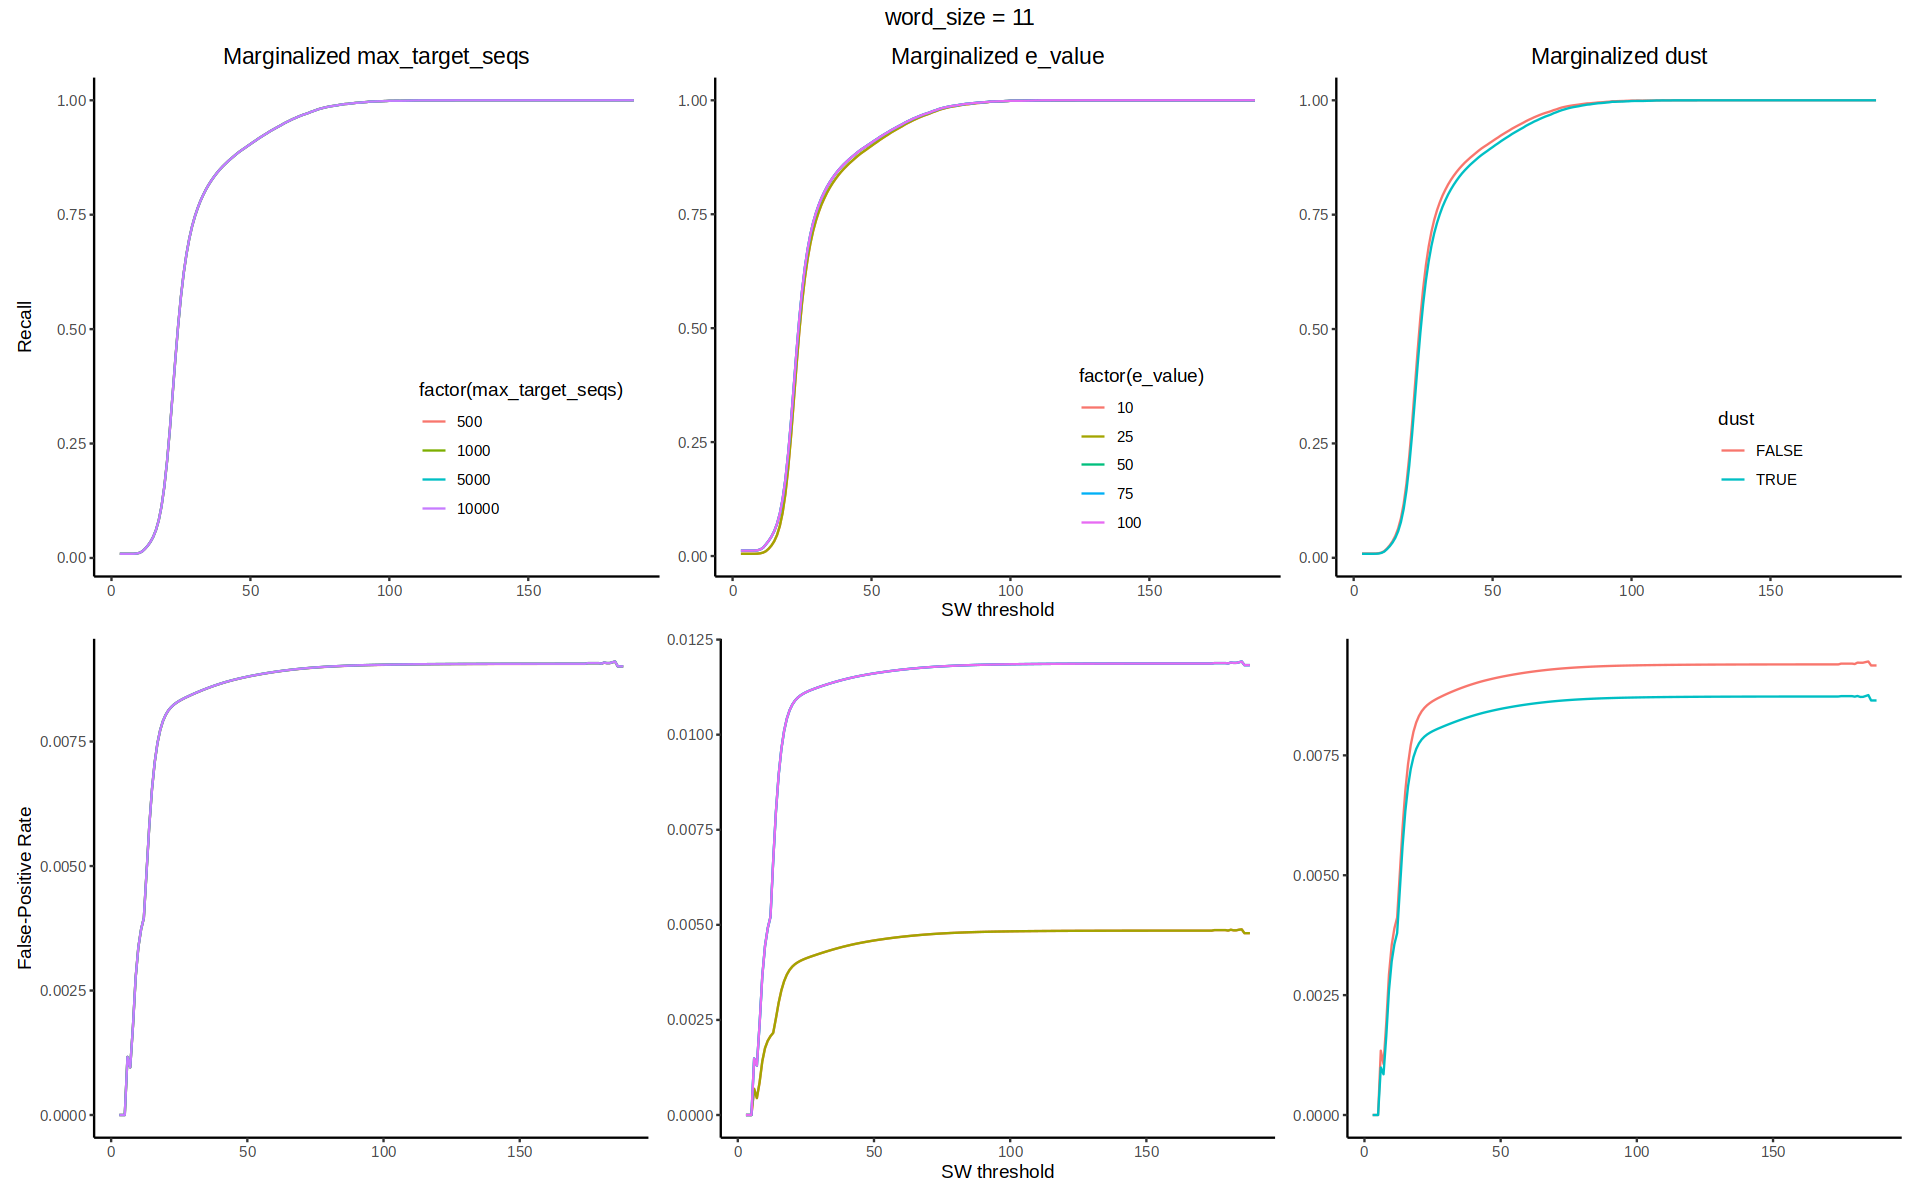

`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'threshold'. You can override using the `.groups` argument.


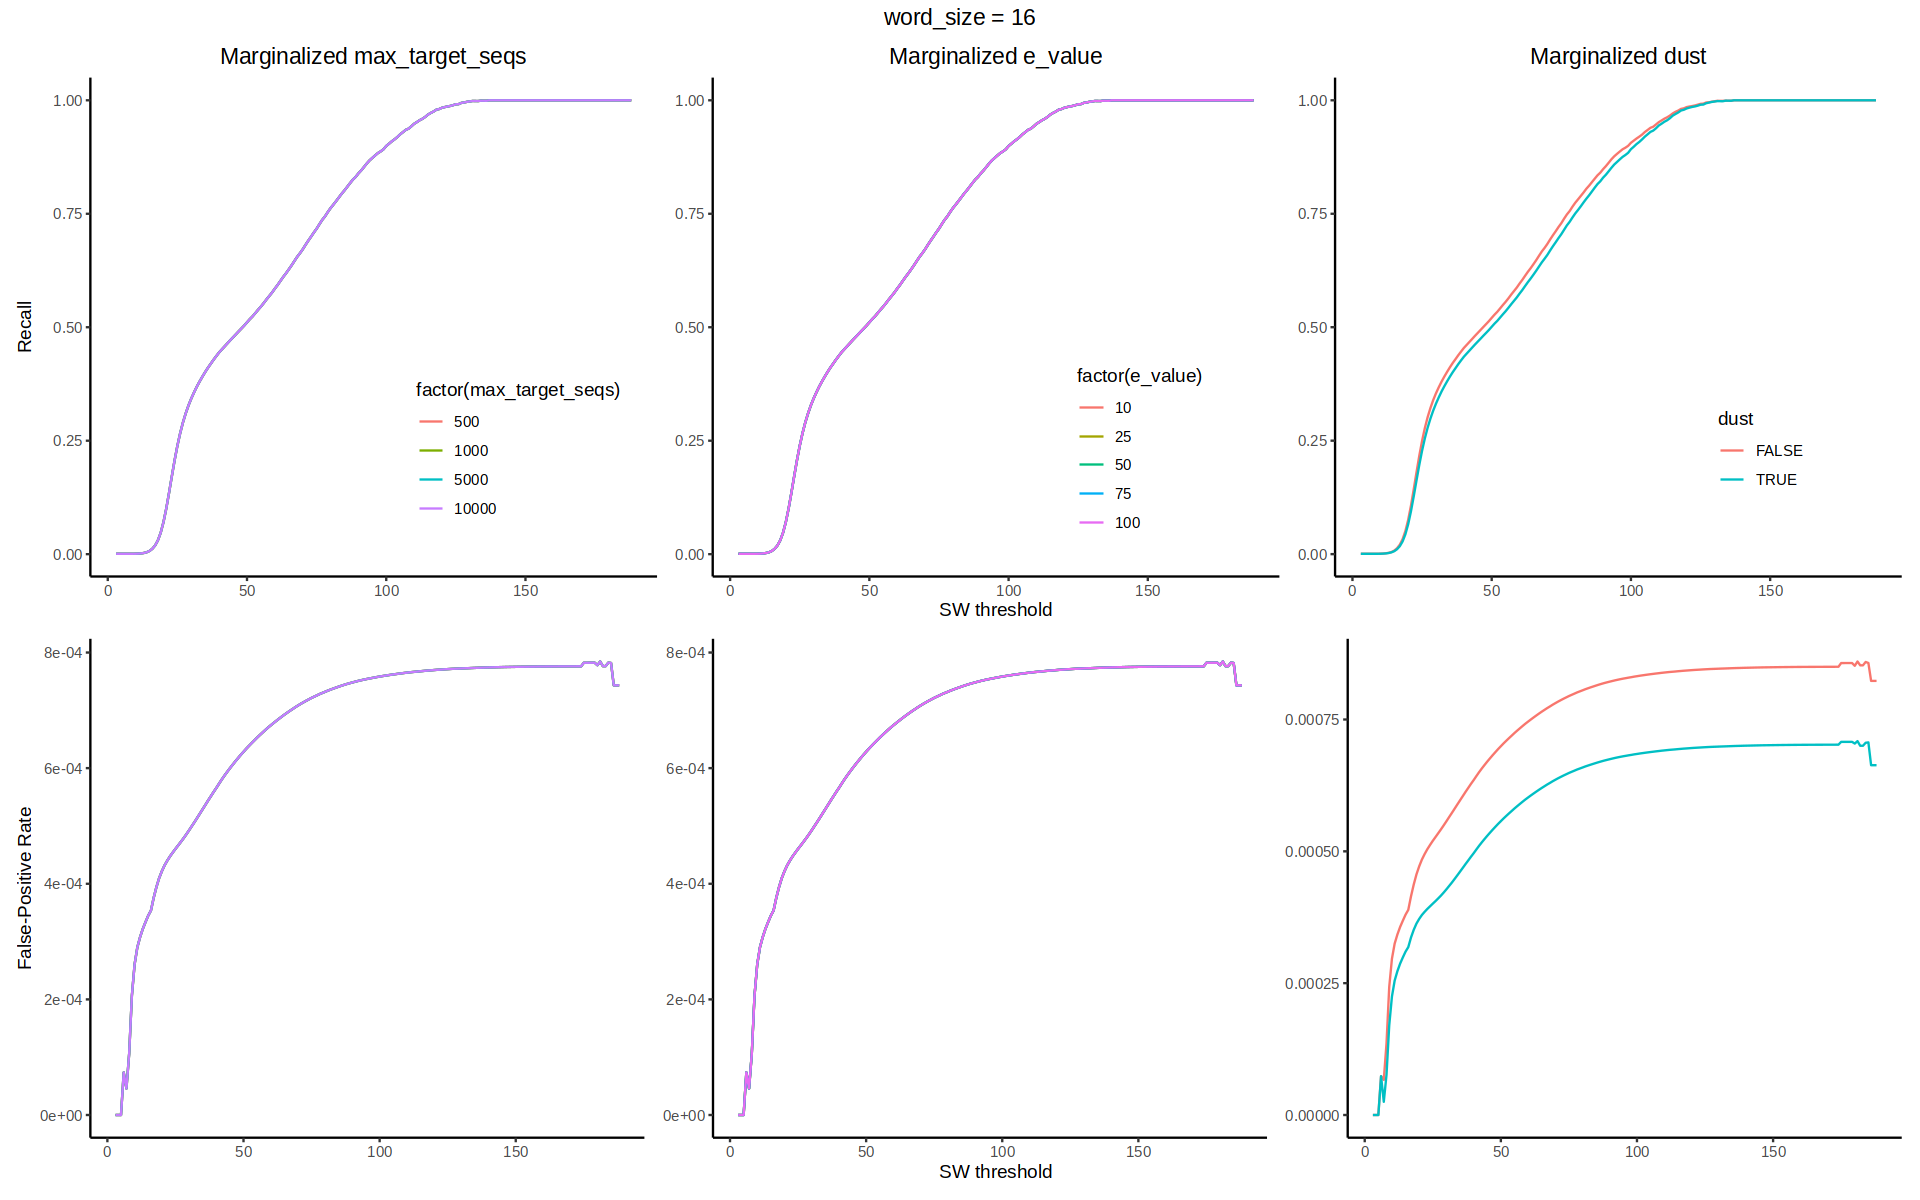

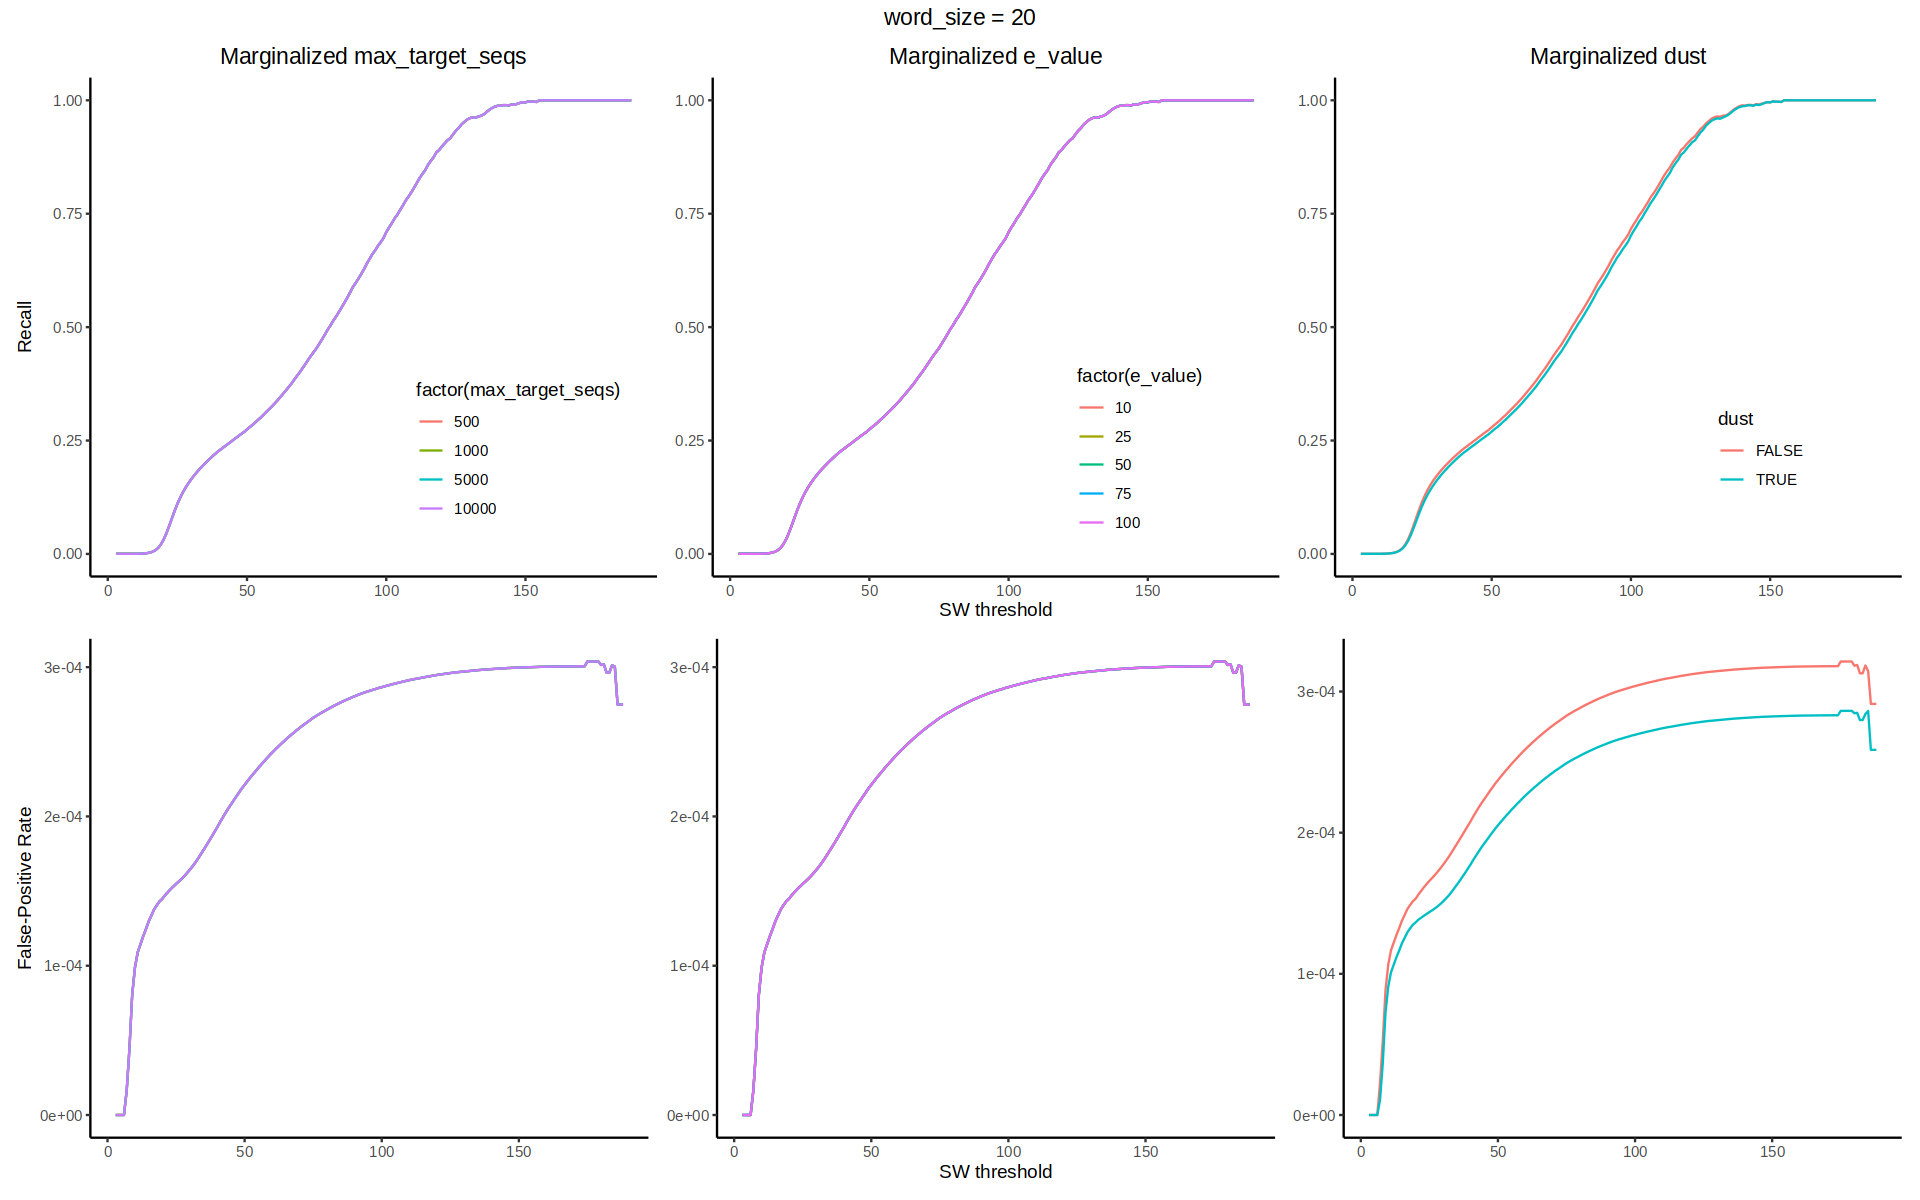

In [6]:
options(repr.plot.width=16,repr.plot.height=10)
for (w in unique(processed_df$word_size)) {
    p_max_target_seqs_recall <- processed_df %>%
        filter(word_size == w) %>%
        group_by(threshold,max_target_seqs) %>%
        summarize(avg_recall = mean(avg_recall)) %>%
        ggplot(aes(x=threshold,y=avg_recall,color=factor(max_target_seqs),group=factor(max_target_seqs))) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(title="Marginalized max_target_seqs",x="SW threshold",y="Recall") +
        theme_classic() + theme(
            legend.position = c(0.75,0.25),
            plot.title = element_text(hjust=0.5)
        )
    p_e_value_recall <- processed_df %>%
        filter(word_size == w) %>%
        group_by(threshold,e_value) %>%
        summarize(avg_recall = mean(avg_recall)) %>%
        ggplot(aes(x=threshold,y=avg_recall,color=factor(e_value),group=factor(e_value))) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(title="Marginalized e_value",x="SW threshold",y="Recall") +
        theme_classic() + theme(
            legend.position = c(0.75,0.25),
            plot.title = element_text(hjust=0.5)
        )
    p_dust_recall <- processed_df %>%
        filter(word_size == w) %>%
        group_by(threshold,dust) %>%
        summarize(avg_recall = mean(avg_recall)) %>%
        ggplot(aes(x=threshold,y=avg_recall,color=dust,group=dust)) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(title="Marginalized dust",x="SW threshold",y="Recall") +
        theme_classic() + theme(
            legend.position = c(0.75,0.25),
            plot.title = element_text(hjust=0.5)
        )
    
    p_max_target_seqs_fpr <- processed_df %>%
        filter(word_size == w) %>%
        group_by(threshold,max_target_seqs) %>%
        summarize(avg_fpr = mean(avg_fpr)) %>%
        ggplot(aes(x=threshold,y=avg_fpr,color=factor(max_target_seqs),group=factor(max_target_seqs))) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(x="SW threshold",y="False-Positive Rate") +
        theme_classic() + theme(
            legend.position = "none"
        )
    p_e_value_seqs_fpr <- processed_df %>%
        filter(word_size == w) %>%
        group_by(threshold,e_value) %>%
        summarize(avg_fpr = mean(avg_fpr)) %>%
        ggplot(aes(x=threshold,y=avg_fpr,color=factor(e_value),group=factor(e_value))) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(x="SW threshold",y="False-Positive Rate") +
        theme_classic() + theme(
            legend.position = "none"
        )
    p_dust_fpr <- processed_df %>%
        filter(word_size == w) %>%
        group_by(threshold,dust) %>%
        summarize(avg_fpr = mean(avg_fpr)) %>%
        ggplot(aes(x=threshold,y=avg_fpr,color=dust,group=dust)) +
        geom_line(linewidth=0.5,alpha=1) +
        labs(x="SW threshold",y="False-Positive Rate") +
        theme_classic() + theme(
            legend.position = "none"
        )
    p <- (((p_max_target_seqs_recall | p_e_value_recall | p_dust_recall) + plot_layout(axis_titles ="collect")) / ((p_max_target_seqs_fpr | p_e_value_seqs_fpr | p_dust_fpr) + plot_layout(axis_titles ="collect"))) +
        plot_annotation(
            paste0("word_size = ",w),
            theme = theme(
                plot.title = element_text(hjust=0.5)
            )
        )
    print(p)
}

# Recall analysis (complete dataset)

In [3]:
recall7_path <- file.path(recall_dir,"complete","K562_clean.complete.wordsize_7.recall","K562_clean.complete.wordsize_7.compiled_recall.csv.gz")
recall11_path <- file.path(recall_dir,"complete","K562_clean.complete.wordsize_11.recall","K562_clean.complete.wordsize_11.compiled_recall.csv.gz")

In [4]:
recall7_df <- read.csv(recall7_path)
recall7_df$word_size <- 7
recall11_df <- read.csv(recall11_path)
recall11_df$word_size <- 11

recall_df <- rbind(recall7_df,recall11_df)
head(recall_df)
dim(recall_df)

,threshold,TP,FP,TN,FN,recall,FPR,word_size
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,170174,0,0,99829826,0.001701740,0,7
2,4,170174,0,0,99829826,0.001701740,0,7
3,5,170174,0,2,99829824,0.001701740,0,7
4,6,170174,0,356,99829470,0.001701746,0,7
5,7,170174,0,28108,99801718,0.001702218,0,7
6,8,170174,0,703812,99126014,0.001713802,0,7


[1] 108504      8

In [5]:
processed_df <- recall_df %>%
    group_by(word_size,threshold) %>%
    summarize(
        total_tp = sum(TP),
        total_fp = sum(FP),
        total_tn = sum(TN),
        total_fn = sum(FN)
    ) %>%
    mutate(
        total_n = total_tp+total_fp+total_tn+total_fn,
        recall = ifelse((total_tp+total_fn) > 0, total_tp/(total_tp+total_fn), 0),
        fpr = ifelse((total_fp+total_tn) > 0, total_fp/(total_fp+total_tn), 0)
    )
head(processed_df)
dim(processed_df)

`summarise()` has grouped output by 'word_size'. You can override using the `.groups`
argument.


word_size,threshold,total_tp,total_fp,total_tn,total_fn,total_n,recall,fpr
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,3,49036233,0,0,26526623767,26575660000,0.001845156,0
7,4,49036233,0,573,26526623194,26575660000,0.001845156,0
7,5,49036233,0,31775,26526591992,26575660000,0.001845158,0
7,6,49036233,0,832553,26525791214,26575660000,0.001845214,0
7,7,49036233,0,30414273,26496209494,26575660000,0.001847270,0
7,8,49036233,0,395464679,26131159088,26575660000,0.001873028,0


[1] 396   9

In [30]:
library(ggrepel)

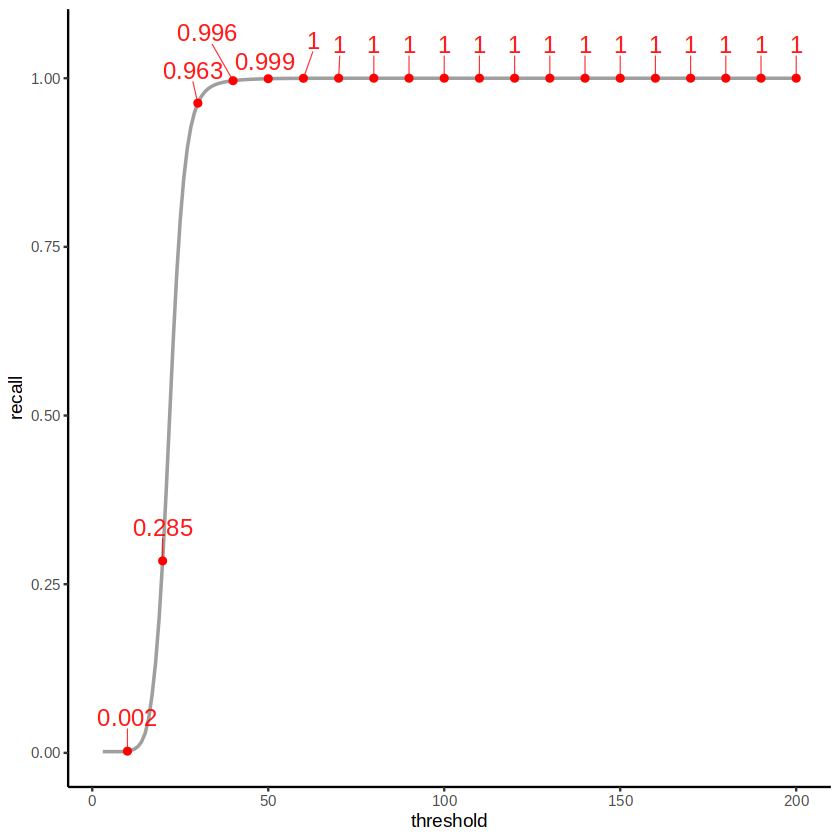

In [47]:
processed_df %>%
    filter(word_size == 7) %>%
    mutate(label = ifelse(threshold %% 10 == 0,round(recall,3),NA)) %>%
    ggplot(aes(x=threshold,y=recall)) +
    geom_line(color="#404040",linewidth=0.75,alpha=0.5) +
    geom_point(data = . %>% filter(!is.na(label)),color="red") +
    geom_text_repel(data = . %>% filter(!is.na(label)),aes(label=label),color="red",
                    size = 5,
                    alpha = 0.9,
                    nudge_y = 0.05,
                    segment.size = .25,
                    segment.alpha = .8,
                    force = 1) +
    theme_classic()

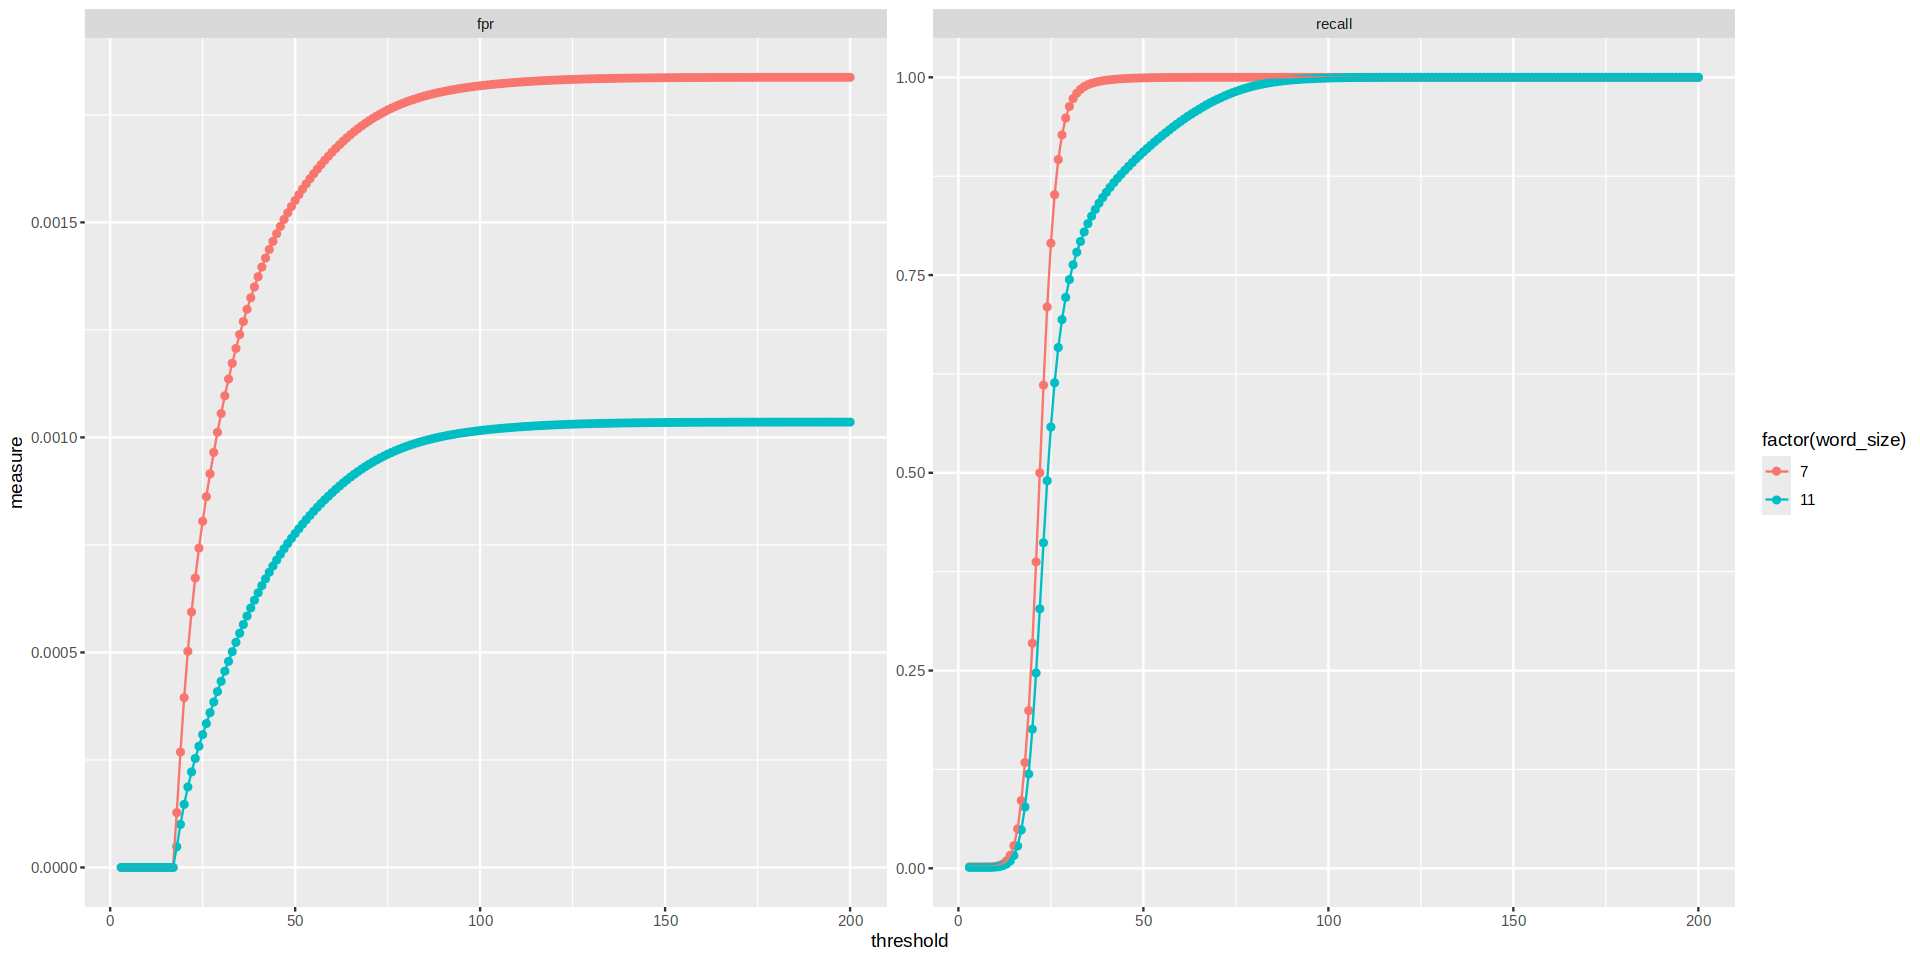

In [34]:
options(repr.plot.width=16,repr.plot.height=8)
processed_df %>%
    pivot_longer(cols=c("recall","fpr"),names_to="statistic",values_to="measure") %>%
    ggplot(aes(x=threshold,y=measure,color=factor(word_size))) +
    geom_point() +
    geom_line() +
    facet_wrap(~statistic,nrow=1,scales="free_y")